# Define Libraries

In [40]:

# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.
# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
import os
import tempfile
import time
from datetime import datetime
import uuid
import joblib
import uuid
from sklearn.metrics import roc_auc_score
from datetime import datetime, timedelta
import gcsfs
import duckdb as dd
import pickle
import joblib
from typing import Union
import io
import polars as pl
path = r'C:\Users\Dwaipayan\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')
os.environ["GOOGLE_CLOUD_PROJECT"] = "prj-prod-dataplatform"
# %% [markdown]
## Configure Settings
# Set options or configurations as needed
pd.set_option('display.max_columns', None)
pd.set_option("Display.max_rows", 100)


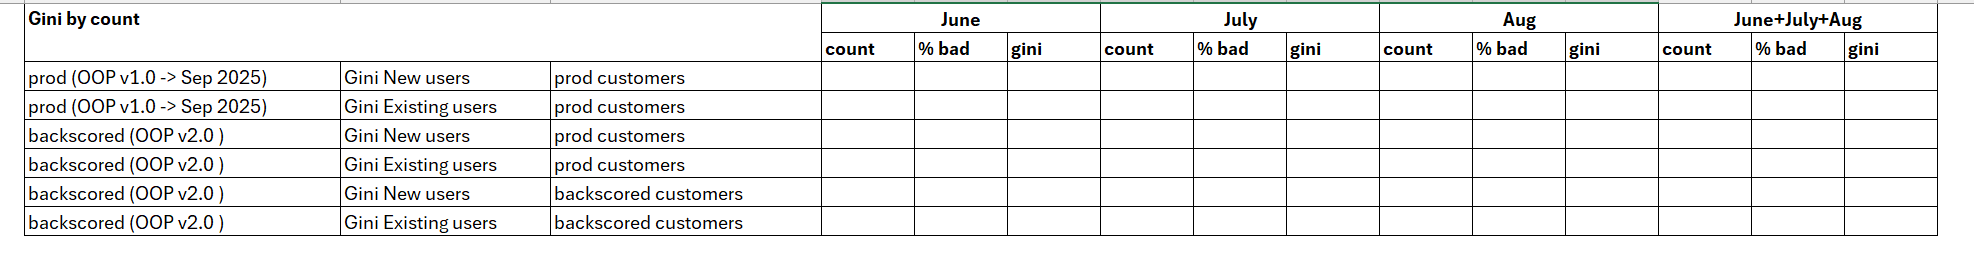

    Notes		
    "Prod customers - this means you have to get customer base from prod table.
    Prod new customers - tendo_mart.tendo_scorecard_master_table_api
    Prod existing customers - tendo_mart.tendo_scorecard_master_table
    Backscored scores for prod customers - this means you have to get customer base from prod table but get scores from backscored tables
    Backscored scores for backscored customers - this means you have to get customer base from backscored table and their corresponding scores
    Backscored table for new customers - risk_mart.tendo_backscored_new_users_jan23_jan26_20260201_oop_with_osbal
    Backscored table for existing customers - risk_mart.tendo_backscored_existing_users_jan23_jan26_20260201_oop
    OSbal values for any purpose you can get only from risk_mart.tendo_backscored_new_users_jan23_jan26_20260201_oop_with_osbal,"		


# Current_date

In [41]:
current_date = datetime.now().strftime('%Y_%m_%d')

# Gini By Count

## Prod (OOP V1.0 -> Sep 2025) - Gini New Users

In [42]:
filname = "oopv1_0sep2025_gininewuser"

In [43]:
sq = """
with b1 as (
  select t1.employee_id, t1.ee_appln_submit_dt,
  user_timelines.first_account_activated_at as ee_onboarding_date,
  t1.run_date,
  t1.attrition_model_name,
  t1.ee_attrition_feature,
  t1.ee_attrition_risk_segment,
  t1.ee_attrition_time_to_leave,
  t1.oop_model_name,
  t1.oop_feature,
  t1.oop_score,
  t1.oop_risk_segment,
  t1.subscription_name,
  t1.message_id,
  t1.publish_time,
  t1.attributes
  from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table_api t1
  left join tendopay_raw.user_timelines on cast(user_timelines.user_id as string) = cast(t1.employee_id as string)
  where user_timelines.first_account_activated_at >= '2025-06-01'
    and user_timelines.first_account_activated_at <= '2025-08-31'
  qualify row_number() over(partition by t1.employee_id order by t1.run_date) = 1
),
b2 as (
  select distinct employee_id, run_date, oop_score
  from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table_api
 ),
b3 as (
  select
    b1.employee_id,
    b1.ee_onboarding_date,
    format_date('%Y-%m', date(b1.ee_onboarding_date)) onboarding_month,
    b2.run_date,
    format_date('%Y-%m', date(b2.run_date)) score_month,
    abs(date_diff(date(b2.run_date), date(b1.ee_onboarding_date), day)) as ddiff,
    b1.oop_score,
    b2.oop_score b2oopscore,
    b1.oop_risk_segment
  from b1
  inner join b2 on b2.employee_id = b1.employee_id  -- Use INNER JOIN if you only want matches
)
select b3.*, 
case when b4.target = 0 then 1 
     when b4.target = 1 then 0 
     else 0 end as target, 
b4.target_maturity_flag
from b3
left join prj-prod-dataplatform.tendo_mart.tendo_collection_target_master b4 on b4.user_id = b3.employee_id
where b4.target_maturity_flag = 1
and b3.ddiff < 2 -- Only include records within 2 days of onboarding
qualify row_number() over(partition by b3.employee_id order by b3.ddiff) = 1
order by ee_onboarding_date;
"""

dfd = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The shape of the dataframe is: {dfd.shape}")

dfd.head()

Job ID 48714060-ba7b-4459-a5be-084f353c2f86 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The shape of the dataframe is: (117, 11)


,employee_id,ee_onboarding_date,onboarding_month,run_date,score_month,ddiff,oop_score,b2oopscore,oop_risk_segment,target,target_maturity_flag
0,1462050,2025-06-20 15:25:58+00:00,2025-06,2025-06-20T07:19:49.145921,2025-06,0,0.548142,0.548142,B,1,1
1,1462044,2025-06-21 16:28:01+00:00,2025-06,2025-06-21T08:25:32.194565,2025-06,0,0.559482,0.559482,B,0,1
2,1454272,2025-06-23 13:59:42+00:00,2025-06,2025-06-23T05:55:47.513153,2025-06,0,0.574867,0.574867,A,1,1
3,1470980,2025-07-02 14:32:29+00:00,2025-07,2025-07-02T06:32:10.299994,2025-07,0,0.515797,0.515797,B,0,1
4,1471414,2025-07-03 10:47:02+00:00,2025-07,2025-07-03T02:44:57.825211,2025-07,0,0.571182,0.571182,A,0,1


In [44]:
dd.query("""select employee_id, count(employee_id) from dfd group by employee_id having count(employee_id) > 1;""")

┌─────────────┬────────────────────┐
│ employee_id │ count(employee_id) │
│   varchar   │       int64        │
├─────────────┴────────────────────┤
│              0 rows              │
└──────────────────────────────────┘

In [45]:
dfd.groupby('onboarding_month').agg({'employee_id':'nunique'})

,employee_id
onboarding_month,
2025-06,3
2025-07,76
2025-08,38


### Monthly Gini

In [46]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_gini(y_true, y_pred):
    """
    Calculate Gini coefficient from actual values and predicted scores.
    Gini = 2 * AUC - 1
    """
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

def gini_by_group(df, score_col, target_col, group_col):
    """
    Calculate Gini coefficient for each group.
    """
    gini_results = {}
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        if len(group_data) > 0 and group_data[target_col].nunique() > 1:
            gini = calculate_gini(group_data[target_col], group_data[score_col])
            gini_results[group] = gini
        else:
            gini_results[group] = np.nan
    return gini_results

def calculate_bad_metrics(df, target_col, maturity_flag_col):
    """
    Calculate count of bad and percentage of bad.
    Bad = target / target_maturity_flag
    """
    count_bad = (df[target_col] / df[maturity_flag_col]).sum()
    total_count = len(df)
    pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
    return count_bad, pct_bad

def bad_metrics_by_group(df, target_col, maturity_flag_col, group_col):
    """
    Calculate bad metrics for each group.
    """
    bad_results = {'count_bad': {}, 'pct_bad': {}}
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        if len(group_data) > 0:
            count_bad, pct_bad = calculate_bad_metrics(group_data, target_col, maturity_flag_col)
            bad_results['count_bad'][group] = count_bad
            bad_results['pct_bad'][group] = pct_bad
    return bad_results

def combined_gini(df, score_cols, target_col):
    """
    Calculate combined Gini for multiple score columns.
    Uses average of normalized scores as combined score.
    """
    # Normalize scores to [0, 1] range
    normalized_scores = pd.DataFrame()
    for col in score_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            normalized_scores[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_scores[col] = 0
    
    # Combined score is average of normalized scores
    combined_score = normalized_scores.mean(axis=1)
    combined_gini_val = calculate_gini(df[target_col], combined_score)
    
    return combined_gini_val

# Load your data
df = dfd.copy()  # Replace with your actual data file

print("=" * 90)
print("GINI COEFFICIENT ANALYSIS WITH BAD METRICS")
print("=" * 90)

# Calculate overall bad metrics
overall_count_bad, overall_pct_bad = calculate_bad_metrics(df, 'target', 'target_maturity_flag')
print(f"\nOVERALL BAD METRICS:")
print(f"  Count of Bad: {overall_count_bad:.2f}")
print(f"  Percentage of Bad: {overall_pct_bad:.2f}%")

# 1. Gini by onboarding_month
print("\n1. GINI BY ONBOARDING_MONTH")
print("-" * 90)
gini_onboarding_oop = gini_by_group(df, 'oop_score', 'target', 'onboarding_month')
gini_onboarding_b2oop = gini_by_group(df, 'b2oopscore', 'target', 'onboarding_month')
bad_onboarding = bad_metrics_by_group(df, 'target', 'target_maturity_flag', 'onboarding_month')

for month in sorted(gini_onboarding_oop.keys()):
    print(f"Month: {month}")
    print(f"  OOP Score Gini:     {gini_onboarding_oop[month]:.6f}")
    print(f"  B2OOP Score Gini:   {gini_onboarding_b2oop[month]:.6f}")
    print(f"  Count of Bad:       {bad_onboarding['count_bad'][month]:.2f}")
    print(f"  Percentage of Bad:  {bad_onboarding['pct_bad'][month]:.2f}%")
    print()

# 2. Gini by score_month
print("\n2. GINI BY SCORE_MONTH")
print("-" * 90)
gini_score_oop = gini_by_group(df, 'oop_score', 'target', 'score_month')
gini_score_b2oop = gini_by_group(df, 'b2oopscore', 'target', 'score_month')
bad_score = bad_metrics_by_group(df, 'target', 'target_maturity_flag', 'score_month')

for month in sorted(gini_score_oop.keys()):
    print(f"Month: {month}")
    print(f"  OOP Score Gini:     {gini_score_oop[month]:.6f}")
    print(f"  B2OOP Score Gini:   {gini_score_b2oop[month]:.6f}")
    print(f"  Count of Bad:       {bad_score['count_bad'][month]:.2f}")
    print(f"  Percentage of Bad:  {bad_score['pct_bad'][month]:.2f}%")
    print()

# 3. Overall Gini (combined for entire dataset)
print("\n3. OVERALL GINI (ENTIRE DATASET)")
print("-" * 90)
overall_gini_oop = calculate_gini(df['target'], df['oop_score'])
overall_gini_b2oop = calculate_gini(df['target'], df['b2oopscore'])
overall_combined_gini = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')

print(f"OOP Score Gini:           {overall_gini_oop:.6f}")
print(f"B2OOP Score Gini:         {overall_gini_b2oop:.6f}")
print(f"Combined Gini:            {overall_combined_gini:.6f}")
print()

# 4. Create summary DataFrame for export
print("\n4. SUMMARY TABLES")
print("-" * 90)

# Summary by onboarding_month
summary_onboarding = pd.DataFrame({
    'onboarding_month': list(gini_onboarding_oop.keys()),
    'oop_score_gini': list(gini_onboarding_oop.values()),
    'b2oopscore_gini': list(gini_onboarding_b2oop.values()),
    'count_bad': list(bad_onboarding['count_bad'].values()),
    'pct_bad': list(bad_onboarding['pct_bad'].values())
})
summary_onboarding['combined_gini'] = summary_onboarding['onboarding_month'].apply(
    lambda m: combined_gini(df[df['onboarding_month'] == m], ['oop_score', 'b2oopscore'], 'target')
    if len(df[df['onboarding_month'] == m]) > 0 and df[df['onboarding_month'] == m]['target'].nunique() > 1
    else np.nan
)
print("\nONBOARDING MONTH SUMMARY:")
print(summary_onboarding.to_string(index=False))

# Summary by score_month
summary_score = pd.DataFrame({
    'score_month': list(gini_score_oop.keys()),
    'oop_score_gini': list(gini_score_oop.values()),
    'b2oopscore_gini': list(gini_score_b2oop.values()),
    'count_bad': list(bad_score['count_bad'].values()),
    'pct_bad': list(bad_score['pct_bad'].values())
})
summary_score['combined_gini'] = summary_score['score_month'].apply(
    lambda m: combined_gini(df[df['score_month'] == m], ['oop_score', 'b2oopscore'], 'target')
    if len(df[df['score_month'] == m]) > 0 and df[df['score_month'] == m]['target'].nunique() > 1
    else np.nan
)
print("\nSCORE MONTH SUMMARY:")
print(summary_score.to_string(index=False))

# Export to Excel
with pd.ExcelWriter(f'{current_date}_gini_analysis_results{filname}.xlsx', engine='openpyxl') as writer:
    summary_onboarding.to_excel(writer, sheet_name='Gini by Onboarding Month', index=False)
    summary_score.to_excel(writer, sheet_name='Gini by Score Month', index=False)
    
    # Overall summary
    overall_summary = pd.DataFrame({
        'Metric': ['OOP Score Gini', 'B2OOP Score Gini', 'Combined Gini', 'Count of Bad', 'Percentage of Bad'],
        'Value': [overall_gini_oop, overall_gini_b2oop, overall_combined_gini, overall_count_bad, overall_pct_bad]
    })
    overall_summary.to_excel(writer, sheet_name='Overall Summary', index=False)

print("\n✓ Results exported to 'gini_analysis_results.xlsx'")

GINI COEFFICIENT ANALYSIS WITH BAD METRICS

OVERALL BAD METRICS:
  Count of Bad: 73.00
  Percentage of Bad: 62.39%

1. GINI BY ONBOARDING_MONTH
------------------------------------------------------------------------------------------
Month: 2025-06
  OOP Score Gini:     0.000000
  B2OOP Score Gini:   0.000000
  Count of Bad:       2.00
  Percentage of Bad:  66.67%

Month: 2025-07
  OOP Score Gini:     0.030990
  B2OOP Score Gini:   0.030990
  Count of Bad:       49.00
  Percentage of Bad:  64.47%

Month: 2025-08
  OOP Score Gini:     0.017045
  B2OOP Score Gini:   -0.005682
  Count of Bad:       22.00
  Percentage of Bad:  57.89%


2. GINI BY SCORE_MONTH
------------------------------------------------------------------------------------------
Month: 2025-06
  OOP Score Gini:     0.000000
  B2OOP Score Gini:   0.000000
  Count of Bad:       2.00
  Percentage of Bad:  66.67%

Month: 2025-07
  OOP Score Gini:     0.030990
  B2OOP Score Gini:   0.030990
  Count of Bad:       49.00
  Perc

In [47]:
summary_score

,score_month,oop_score_gini,b2oopscore_gini,count_bad,pct_bad,combined_gini
0,2025-06,0.000000,0.000000,2.0,66.666667,0.000000
1,2025-07,0.030990,0.030990,49.0,64.473684,0.030990
2,2025-08,0.017045,-0.005682,22.0,57.894737,0.011364


### Overall Gini Analysis

In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_gini(y_true, y_pred):
    """
    Calculate Gini coefficient from actual values and predicted scores.
    Gini = 2 * AUC - 1
    """
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

def calculate_bad_metrics(df, target_col, maturity_flag_col):
    """
    Calculate count of bad and percentage of bad.
    Bad = target / target_maturity_flag
    """
    count_bad = (df[target_col] / df[maturity_flag_col]).sum()
    total_count = len(df)
    pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
    return count_bad, pct_bad

def combined_gini(df, score_cols, target_col):
    """
    Calculate combined Gini for multiple score columns.
    Uses average of normalized scores as combined score.
    """
    # Normalize scores to [0, 1] range
    normalized_scores = pd.DataFrame()
    for col in score_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            normalized_scores[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_scores[col] = 0
    
    # Combined score is average of normalized scores
    combined_score = normalized_scores.mean(axis=1)
    combined_gini_val = calculate_gini(df[target_col], combined_score)
    
    return combined_gini_val

# Load your data
df = dfd.copy()  # Replace with your actual data file

print("=" * 90)
print("OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)")
print("=" * 90)

# Dataset Information
print(f"\nDATASET INFORMATION:")
print(f"  Total Records: {len(df)}")
print(f"  Target Value Counts:\n{df['target'].value_counts()}")

# Overall Bad Metrics
overall_count_bad, overall_pct_bad = calculate_bad_metrics(df, 'target', 'target_maturity_flag')
print(f"\nOVERALL BAD METRICS:")
print(f"  Count of Bad: {overall_count_bad:.4f}")
print(f"  Percentage of Bad: {overall_pct_bad:.4f}%")

# Individual Score Gini
print(f"\nINDIVIDUAL SCORE GINI:")
print("-" * 90)
overall_gini_oop = calculate_gini(df['target'], df['oop_score'])
overall_gini_b2oop = calculate_gini(df['target'], df['b2oopscore'])

print(f"  OOP Score:")
print(f"    Gini: {overall_gini_oop:.6f}")
print(f"    AUC:  {(overall_gini_oop + 1) / 2:.6f}")

print(f"\n  B2OOP Score:")
print(f"    Gini: {overall_gini_b2oop:.6f}")
print(f"    AUC:  {(overall_gini_b2oop + 1) / 2:.6f}")

# Combined Gini
print(f"\nCOMBINED GINI:")
print("-" * 90)
overall_combined_gini = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')

print(f"  Combined Score (Mean Normalized):")
print(f"    Gini: {overall_combined_gini:.6f}")
print(f"    AUC:  {(overall_combined_gini + 1) / 2:.6f}")

# Score Statistics
print(f"\nSCORE STATISTICS:")
print("-" * 90)
print(f"\n  OOP Score:")
print(f"    Min:  {df['oop_score'].min():.6f}")
print(f"    Max:  {df['oop_score'].max():.6f}")
print(f"    Mean: {df['oop_score'].mean():.6f}")
print(f"    Std:  {df['oop_score'].std():.6f}")

print(f"\n  B2OOP Score:")
print(f"    Min:  {df['b2oopscore'].min():.6f}")
print(f"    Max:  {df['b2oopscore'].max():.6f}")
print(f"    Mean: {df['b2oopscore'].mean():.6f}")
print(f"    Std:  {df['b2oopscore'].std():.6f}")

# Create Summary DataFrame
summary_overall = pd.DataFrame({
    'Metric': [
        'OOP Score Gini',
        'OOP Score AUC',
        'B2OOP Score Gini',
        'B2OOP Score AUC',
        'Combined Gini',
        'Combined AUC',
        'Count of Bad',
        'Percentage of Bad',
        'Total Records',
        'Bad Count (target=1)',
        'Good Count (target=0)'
    ],
    'Value': [
        overall_gini_oop,
        (overall_gini_oop + 1) / 2,
        overall_gini_b2oop,
        (overall_gini_b2oop + 1) / 2,
        overall_combined_gini,
        (overall_combined_gini + 1) / 2,
        overall_count_bad,
        overall_pct_bad,
        len(df),
        (df['target'] == 1).sum(),
        (df['target'] == 0).sum()
    ]
})

print(f"\nSUMMARY TABLE:")
print("-" * 90)
print(summary_overall.to_string(index=False))

# Export to Excel
with pd.ExcelWriter(f'{current_date}_gini_overall_analysis_{filname}.xlsx', engine='openpyxl') as writer:
    summary_overall.to_excel(writer, sheet_name='Overall Summary', index=False)
    
    # Detailed score statistics
    score_stats = pd.DataFrame({
        'Score Column': ['OOP Score', 'B2OOP Score'],
        'Min': [df['oop_score'].min(), df['b2oopscore'].min()],
        'Max': [df['oop_score'].max(), df['b2oopscore'].max()],
        'Mean': [df['oop_score'].mean(), df['b2oopscore'].mean()],
        'Median': [df['oop_score'].median(), df['b2oopscore'].median()],
        'Std Dev': [df['oop_score'].std(), df['b2oopscore'].std()],
        'Gini': [overall_gini_oop, overall_gini_b2oop],
        'AUC': [(overall_gini_oop + 1) / 2, (overall_gini_b2oop + 1) / 2]
    })
    score_stats.to_excel(writer, sheet_name='Score Statistics', index=False)

print(f"\n✓ Results exported to '{current_date}_gini_overall_analysis.xlsx'")

OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)

DATASET INFORMATION:
  Total Records: 117
  Target Value Counts:
target
1    73
0    44
Name: count, dtype: Int64

OVERALL BAD METRICS:
  Count of Bad: 73.0000
  Percentage of Bad: 62.3932%

INDIVIDUAL SCORE GINI:
------------------------------------------------------------------------------------------
  OOP Score:
    Gini: 0.019925
    AUC:  0.509963

  B2OOP Score:
    Gini: 0.011208
    AUC:  0.505604

COMBINED GINI:
------------------------------------------------------------------------------------------
  Combined Score (Mean Normalized):
    Gini: 0.015567
    AUC:  0.507783

SCORE STATISTICS:
------------------------------------------------------------------------------------------

  OOP Score:
    Min:  0.381393
    Max:  0.718999
    Mean: 0.535495
    Std:  0.066635

  B2OOP Score:
    Min:  0.381393
    Max:  0.718999
    Mean: 0.534892
    Std:  0.067187

SUMMARY TABLE:
----------------------------------------------------

In [49]:
score_stats

,Score Column,Min,Max,Mean,Median,Std Dev,Gini,AUC
0,OOP Score,0.381393,0.718999,0.535495,0.528347,0.066635,0.019925,0.509963
1,B2OOP Score,0.381393,0.718999,0.534892,0.528347,0.067187,0.011208,0.505604


In [50]:
summary_overall_transposed = summary_overall.set_index('Metric').T
summary_overall_transposed

Metric,OOP Score Gini,OOP Score AUC,B2OOP Score Gini,B2OOP Score AUC,Combined Gini,Combined AUC,Count of Bad,Percentage of Bad,Total Records,Bad Count (target=1),Good Count (target=0)
Value,0.019925,0.509963,0.011208,0.505604,0.015567,0.507783,73.0,62.393162,117.0,73.0,44.0


### Overall gini_analysis_advanced

OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)

DATASET INFORMATION:
  Total Records: 117
  Target Value Counts:
    1: 73
    0: 44

OVERALL BAD METRICS:
  Count of Bad: 73.0000
  Percentage of Bad: 62.3932%

INDIVIDUAL SCORE ANALYSIS:
----------------------------------------------------------------------------------------------------

  oop_score:
    Gini: 0.019925
    AUC:  0.509963
    Statistics:
      Min:    0.381393
      Max:    0.718999
      Mean:   0.535495
      Median: 0.528347
      Std:    0.066635

  b2oopscore:
    Gini: 0.011208
    AUC:  0.505604
    Statistics:
      Min:    0.381393
      Max:    0.718999
      Mean:   0.534892
      Median: 0.528347
      Std:    0.067187

COMBINED GINI ANALYSIS:
----------------------------------------------------------------------------------------------------
  Method 'mean':
    Gini: 0.015567
    AUC:  0.507783
  Method 'median':
    Gini: 0.015567
    AUC:  0.507783
  Method 'max':
    Gini: 0.018680
    AUC:  0.509340
  

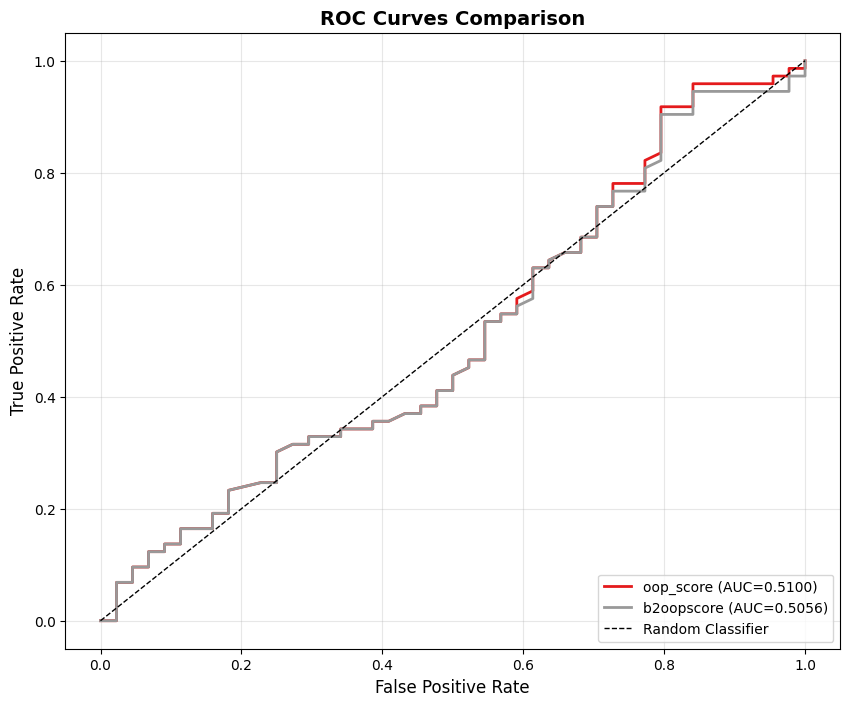

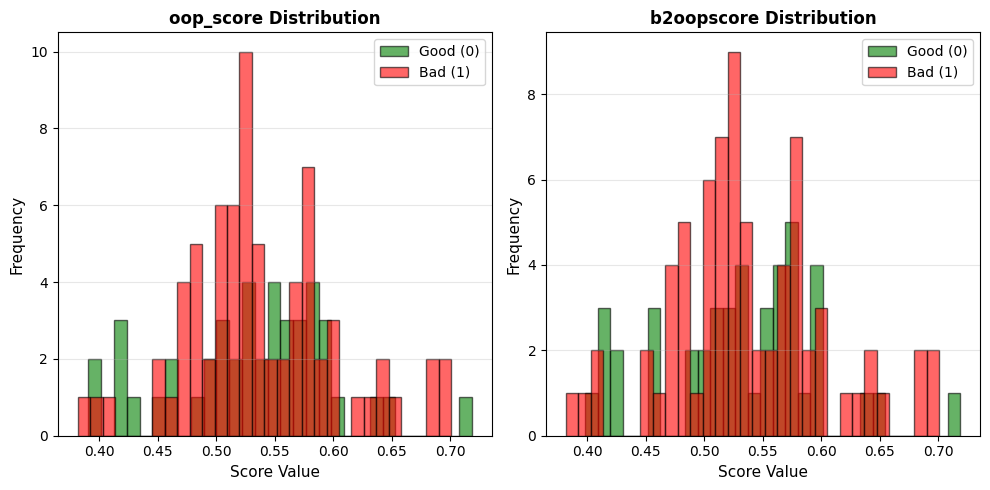

In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

class OverallGiniAnalyzer:
    """
    Overall Gini coefficient analysis without grouping by time periods.
    """
    
    def __init__(self, df, target_col='target', maturity_flag_col='target_maturity_flag'):
        self.df = df.copy()
        self.target_col = target_col
        self.maturity_flag_col = maturity_flag_col
    
    def calculate_gini(self, y_true, y_pred):
        """Gini coefficient: 2*AUC - 1"""
        if y_true.nunique() < 2:
            return np.nan
        auc = roc_auc_score(y_true, y_pred)
        return 2 * auc - 1
    
    def calculate_bad_metrics(self, data=None):
        """Calculate count and percentage of bad"""
        if data is None:
            data = self.df
        count_bad = (data[self.target_col] / data[self.maturity_flag_col]).sum()
        total_count = len(data)
        pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
        return count_bad, pct_bad
    
    def get_score_statistics(self, score_col):
        """Get detailed statistics for a score column"""
        data = self.df[score_col]
        return {
            'Min': data.min(),
            'Max': data.max(),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Q1': data.quantile(0.25),
            'Q3': data.quantile(0.75),
            'Skewness': data.skew(),
            'Kurtosis': data.kurtosis()
        }
    
    def combined_gini(self, score_cols, method='mean'):
        """
        Calculate combined Gini from multiple scores.
        method: 'mean', 'median', 'weighted', 'max', 'min'
        """
        # Normalize scores to [0, 1]
        normalized = pd.DataFrame()
        for col in score_cols:
            min_val = self.df[col].min()
            max_val = self.df[col].max()
            if max_val > min_val:
                normalized[col] = (self.df[col] - min_val) / (max_val - min_val)
            else:
                normalized[col] = 0
        
        # Combine based on method
        if method == 'mean':
            combined_score = normalized.mean(axis=1)
        elif method == 'median':
            combined_score = normalized.median(axis=1)
        elif method == 'max':
            combined_score = normalized.max(axis=1)
        elif method == 'min':
            combined_score = normalized.min(axis=1)
        elif method == 'weighted':
            # Weight by individual Gini scores
            weights = []
            for col in score_cols:
                gini = self.calculate_gini(self.df[self.target_col], self.df[col])
                weights.append(max(gini, 0) + 1)
            weights = np.array(weights) / sum(weights)
            combined_score = (normalized * weights).sum(axis=1)
        
        return self.calculate_gini(self.df[self.target_col], combined_score)
    
    def roc_metrics(self, score_col):
        """Calculate ROC curve metrics"""
        fpr, tpr, thresholds = roc_curve(self.df[self.target_col], self.df[score_col])
        auc = roc_auc_score(self.df[self.target_col], self.df[score_col])
        gini = 2 * auc - 1
        return {'fpr': fpr, 'tpr': tpr, 'auc': auc, 'gini': gini, 'thresholds': thresholds}
    
    def print_summary(self, score_cols):
        """Print comprehensive summary"""
        print("=" * 100)
        print("OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)")
        print("=" * 100)
        
        # Dataset info
        print(f"\nDATASET INFORMATION:")
        print(f"  Total Records: {len(self.df)}")
        print(f"  Target Value Counts:")
        for val, count in self.df[self.target_col].value_counts().items():
            print(f"    {val}: {count}")
        
        # Bad metrics
        count_bad, pct_bad = self.calculate_bad_metrics()
        print(f"\nOVERALL BAD METRICS:")
        print(f"  Count of Bad: {count_bad:.4f}")
        print(f"  Percentage of Bad: {pct_bad:.4f}%")
        
        # Individual scores
        print(f"\nINDIVIDUAL SCORE ANALYSIS:")
        print("-" * 100)
        for score_col in score_cols:
            gini = self.calculate_gini(self.df[self.target_col], self.df[score_col])
            auc = (gini + 1) / 2
            print(f"\n  {score_col}:")
            print(f"    Gini: {gini:.6f}")
            print(f"    AUC:  {auc:.6f}")
            
            # Statistics
            stats = self.get_score_statistics(score_col)
            print(f"    Statistics:")
            print(f"      Min:    {stats['Min']:.6f}")
            print(f"      Max:    {stats['Max']:.6f}")
            print(f"      Mean:   {stats['Mean']:.6f}")
            print(f"      Median: {stats['Median']:.6f}")
            print(f"      Std:    {stats['Std Dev']:.6f}")
        
        # Combined Gini with different methods
        print(f"\nCOMBINED GINI ANALYSIS:")
        print("-" * 100)
        methods = ['mean', 'median', 'max', 'min', 'weighted']
        for method in methods:
            combined = self.combined_gini(score_cols, method=method)
            auc = (combined + 1) / 2
            print(f"  Method '{method}':")
            print(f"    Gini: {combined:.6f}")
            print(f"    AUC:  {auc:.6f}")
    
    def plot_roc_curves(self, score_cols, save_path=None):
        """Plot ROC curves for all scores"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(score_cols)))
        
        for score_col, color in zip(score_cols, colors):
            metrics = self.roc_metrics(score_col)
            ax.plot(metrics['fpr'], metrics['tpr'], label=f"{score_col} (AUC={metrics['auc']:.4f})", 
                   color=color, linewidth=2)
        
        # Diagonal line (random classifier)
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def plot_score_distributions(self, score_cols, save_path=None):
        """Plot distribution of scores by target"""
        fig, axes = plt.subplots(1, len(score_cols), figsize=(5*len(score_cols), 5))
        if len(score_cols) == 1:
            axes = [axes]
        
        for ax, score_col in zip(axes, score_cols):
            bad_scores = self.df[self.df[self.target_col] == 1][score_col]
            good_scores = self.df[self.df[self.target_col] == 0][score_col]
            
            ax.hist(good_scores, bins=30, alpha=0.6, label='Good (0)', color='green', edgecolor='black')
            ax.hist(bad_scores, bins=30, alpha=0.6, label='Bad (1)', color='red', edgecolor='black')
            
            ax.set_xlabel('Score Value', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'{score_col} Distribution', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def export_results(self, score_cols, filename=f'{current_date}_gini_overall_detailed{filname}.xlsx'):
        """Export comprehensive results to Excel"""
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # Summary metrics
            summary_data = []
            for score_col in score_cols:
                gini = self.calculate_gini(self.df[self.target_col], self.df[score_col])
                auc = (gini + 1) / 2
                summary_data.append({
                    'Score Column': score_col,
                    'Gini': gini,
                    'AUC': auc
                })
            
            # Add combined methods
            for method in ['mean', 'median', 'max', 'min', 'weighted']:
                combined = self.combined_gini(score_cols, method=method)
                auc = (combined + 1) / 2
                summary_data.append({
                    'Score Column': f'Combined ({method})',
                    'Gini': combined,
                    'AUC': auc
                })
            
            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='Summary', index=False)
            
            # Score statistics
            stats_data = []
            for score_col in score_cols:
                stats = self.get_score_statistics(score_col)
                stats['Score Column'] = score_col
                stats_data.append(stats)
            
            stats_df = pd.DataFrame(stats_data)
            stats_df.to_excel(writer, sheet_name='Score Statistics', index=False)
            
            # Bad metrics
            count_bad, pct_bad = self.calculate_bad_metrics()
            bad_df = pd.DataFrame({
                'Metric': ['Count of Bad', 'Percentage of Bad (%)', 'Total Records', 
                          'Count Bad (target=1)', 'Count Good (target=0)'],
                'Value': [count_bad, pct_bad, len(self.df), 
                         (self.df[self.target_col] == 1).sum(),
                         (self.df[self.target_col] == 0).sum()]
            })
            bad_df.to_excel(writer, sheet_name='Bad Metrics', index=False)
            
            # Dataset overview
            overview_df = pd.DataFrame({
                'Attribute': ['Total Records', 'Target=0', 'Target=1', 
                            'Maturity Flag=0', 'Maturity Flag=1'],
                'Count': [len(self.df),
                         (self.df[self.target_col] == 0).sum(),
                         (self.df[self.target_col] == 1).sum(),
                         (self.df[self.maturity_flag_col] == 0).sum(),
                         (self.df[self.maturity_flag_col] == 1).sum()]
            })
            overview_df.to_excel(writer, sheet_name='Dataset Overview', index=False)


# Usage Example
if __name__ == "__main__":
    # Load data
    df = dfd.copy()
    
    analyzer = OverallGiniAnalyzer(df, target_col='target', maturity_flag_col='target_maturity_flag')
    
    score_cols = ['oop_score', 'b2oopscore']
    
    # Print comprehensive summary
    analyzer.print_summary(score_cols)
    
    # Generate visualizations
    print("\n\nGENERATING VISUALIZATIONS:")
    print("-" * 100)
    analyzer.plot_roc_curves(score_cols, save_path='roc_curves.png')
    print("✓ ROC curves saved to 'roc_curves.png'")
    
    analyzer.plot_score_distributions(score_cols, save_path='score_distributions.png')
    print("✓ Score distributions saved to 'score_distributions.png'")
    
    # Export results
    analyzer.export_results(score_cols, filename='gini_overall_detailed.xlsx')
    print("\n✓ Results exported to 'gini_overall_detailed.xlsx'")

## Prod (OOP V1.0 -> Sep 2025) - Gini Existing Users

In [52]:
filname = "oopv1_0sep2025_giniexistinguser"

In [53]:
sq = """
with b1 as (
  select t1.employee_id, t1.ee_appln_submit_dt,
  user_timelines.first_account_activated_at as ee_onboarding_date,
  t1.run_date,
  t1.attrition_model_name,
  t1.ee_attrition_feature,
  t1.ee_attrition_risk_segment,
  t1.ee_attrition_time_to_leave,
  t1.oop_model_name,
  t1.oop_feature,
  t1.oop_score,
  t1.oop_risk_segment,
  t1.subscription_name,
  t1.message_id,
  t1.publish_time,
  t1.attributes
  from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table_api t1
  left join tendopay_raw.user_timelines on cast(user_timelines.user_id as string) = cast(t1.employee_id as string)
  where user_timelines.first_account_activated_at >= '2025-06-01'
    and user_timelines.first_account_activated_at <= '2025-08-31'
  qualify row_number() over(partition by t1.employee_id order by t1.run_date) = 1
),
b2 as (
  select distinct employee_id, run_date, oop_score
  from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table
 ),
b3 as (
  select
    b1.employee_id,
    b1.ee_onboarding_date,
    format_date('%Y-%m', date(b1.ee_onboarding_date)) onboarding_month,
    b2.run_date,
    format_date('%Y-%m', date(b2.run_date)) score_month,
    abs(date_diff(date(b2.run_date), date(b1.ee_onboarding_date), day)) as ddiff,
    b1.oop_score,
    b2.oop_score b2oopscore,
    b1.oop_risk_segment
  from b1
  inner join b2 on b2.employee_id = b1.employee_id  -- Use INNER JOIN if you only want matches
)
select b3.*, 
case when b4.target = 0 then 1 
     when b4.target = 1 then 0 
     else 0 end as target, 
b4.target_maturity_flag
from b3
left join prj-prod-dataplatform.tendo_mart.tendo_collection_target_master b4 on b4.user_id = b3.employee_id
where b4.target_maturity_flag = 1
--- and b3.ddiff < 2 -- Only include records within 2 days of onboarding
--- qualify row_number() over(partition by b3.employee_id order by b3.ddiff) = 1
order by ee_onboarding_date;
"""

dfd = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The shape of the dataframe is: {dfd.shape}")

dfd.head()

Job ID ae7fca2d-3fdd-467f-b54b-19f944ba5f96 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The shape of the dataframe is: (250, 11)


,employee_id,ee_onboarding_date,onboarding_month,run_date,score_month,ddiff,oop_score,b2oopscore,oop_risk_segment,target,target_maturity_flag
0,1447152,2025-06-03 11:47:44+00:00,2025-06,2025-07-03,2025-07,30,0.571182,0.540031,A,0,1
1,1260893,2025-06-05 16:07:33+00:00,2025-06,2025-07-05,2025-07,30,0.589305,0.501153,B,0,1
2,1451750,2025-06-07 10:45:39+00:00,2025-06,2025-07-07,2025-07,30,0.487756,0.534564,C,0,1
3,1451750,2025-06-07 10:45:39+00:00,2025-06,2025-09-07,2025-09,92,0.487756,0.535801,C,0,1
4,1451750,2025-06-07 10:45:39+00:00,2025-06,2025-08-07,2025-08,61,0.487756,0.534528,C,0,1


In [54]:
dd.query("""select employee_id, count(employee_id) from dfd where onboarding_month = '2025-06' group by employee_id having count(employee_id) > 1 order by 2 desc;""")

┌─────────────┬────────────────────┐
│ employee_id │ count(employee_id) │
│   varchar   │       int64        │
├─────────────┼────────────────────┤
│ 1320855     │                  3 │
│ 1451750     │                  3 │
│ 1454272     │                  3 │
│ 1462050     │                  2 │
└─────────────┴────────────────────┘

In [55]:
dfd[dfd['employee_id'] == '1320855']

,employee_id,ee_onboarding_date,onboarding_month,run_date,score_month,ddiff,oop_score,b2oopscore,oop_risk_segment,target,target_maturity_flag
12,1320855,2025-06-27 16:30:49+00:00,2025-06,2025-08-27,2025-08,61,0.56643,0.496909,A,0,1
13,1320855,2025-06-27 16:30:49+00:00,2025-06,2025-07-27,2025-07,30,0.56643,0.496909,A,0,1
14,1320855,2025-06-27 16:30:49+00:00,2025-06,2025-09-27,2025-09,92,0.56643,0.496550,A,0,1


In [56]:
dfd.groupby('score_month').agg({'employee_id':'nunique'})

,employee_id
score_month,
2025-07,8
2025-08,70
2025-09,80
2025-10,46
2025-11,26
2025-12,15
2026-01,5


### Monthly Gini

In [57]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_gini(y_true, y_pred):
    """
    Calculate Gini coefficient from actual values and predicted scores.
    Gini = 2 * AUC - 1
    """
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

def gini_by_group(df, score_col, target_col, group_col):
    """
    Calculate Gini coefficient for each group.
    """
    gini_results = {}
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        if len(group_data) > 0 and group_data[target_col].nunique() > 1:
            gini = calculate_gini(group_data[target_col], group_data[score_col])
            gini_results[group] = gini
        else:
            gini_results[group] = np.nan
    return gini_results

def calculate_bad_metrics(df, target_col, maturity_flag_col):
    """
    Calculate count of bad and percentage of bad.
    Bad = target / target_maturity_flag
    """
    count_bad = (df[target_col] / df[maturity_flag_col]).sum()
    total_count = len(df)
    pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
    return count_bad, pct_bad

def bad_metrics_by_group(df, target_col, maturity_flag_col, group_col):
    """
    Calculate bad metrics for each group.
    """
    bad_results = {'count_bad': {}, 'pct_bad': {}}
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        if len(group_data) > 0:
            count_bad, pct_bad = calculate_bad_metrics(group_data, target_col, maturity_flag_col)
            bad_results['count_bad'][group] = count_bad
            bad_results['pct_bad'][group] = pct_bad
    return bad_results

def combined_gini(df, score_cols, target_col):
    """
    Calculate combined Gini for multiple score columns.
    Uses average of normalized scores as combined score.
    """
    # Normalize scores to [0, 1] range
    normalized_scores = pd.DataFrame()
    for col in score_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            normalized_scores[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_scores[col] = 0
    
    # Combined score is average of normalized scores
    combined_score = normalized_scores.mean(axis=1)
    combined_gini_val = calculate_gini(df[target_col], combined_score)
    
    return combined_gini_val

# Load your data
df = dfd.copy()  # Replace with your actual data file

print("=" * 90)
print("GINI COEFFICIENT ANALYSIS WITH BAD METRICS")
print("=" * 90)

# Calculate overall bad metrics
overall_count_bad, overall_pct_bad = calculate_bad_metrics(df, 'target', 'target_maturity_flag')
print(f"\nOVERALL BAD METRICS:")
print(f"  Count of Bad: {overall_count_bad:.2f}")
print(f"  Percentage of Bad: {overall_pct_bad:.2f}%")

# 1. Gini by onboarding_month
print("\n1. GINI BY ONBOARDING_MONTH")
print("-" * 90)
gini_onboarding_oop = gini_by_group(df, 'oop_score', 'target', 'onboarding_month')
gini_onboarding_b2oop = gini_by_group(df, 'b2oopscore', 'target', 'onboarding_month')
bad_onboarding = bad_metrics_by_group(df, 'target', 'target_maturity_flag', 'onboarding_month')

for month in sorted(gini_onboarding_oop.keys()):
    print(f"Month: {month}")
    print(f"  OOP Score Gini:     {gini_onboarding_oop[month]:.6f}")
    print(f"  B2OOP Score Gini:   {gini_onboarding_b2oop[month]:.6f}")
    print(f"  Count of Bad:       {bad_onboarding['count_bad'][month]:.2f}")
    print(f"  Percentage of Bad:  {bad_onboarding['pct_bad'][month]:.2f}%")
    print()

# 2. Gini by score_month
print("\n2. GINI BY SCORE_MONTH")
print("-" * 90)
gini_score_oop = gini_by_group(df, 'oop_score', 'target', 'score_month')
gini_score_b2oop = gini_by_group(df, 'b2oopscore', 'target', 'score_month')
bad_score = bad_metrics_by_group(df, 'target', 'target_maturity_flag', 'score_month')

for month in sorted(gini_score_oop.keys()):
    print(f"Month: {month}")
    print(f"  OOP Score Gini:     {gini_score_oop[month]:.6f}")
    print(f"  B2OOP Score Gini:   {gini_score_b2oop[month]:.6f}")
    print(f"  Count of Bad:       {bad_score['count_bad'][month]:.2f}")
    print(f"  Percentage of Bad:  {bad_score['pct_bad'][month]:.2f}%")
    print()

# 3. Overall Gini (combined for entire dataset)
print("\n3. OVERALL GINI (ENTIRE DATASET)")
print("-" * 90)
overall_gini_oop = calculate_gini(df['target'], df['oop_score'])
overall_gini_b2oop = calculate_gini(df['target'], df['b2oopscore'])
overall_combined_gini = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')

print(f"OOP Score Gini:           {overall_gini_oop:.6f}")
print(f"B2OOP Score Gini:         {overall_gini_b2oop:.6f}")
print(f"Combined Gini:            {overall_combined_gini:.6f}")
print()

# 4. Create summary DataFrame for export
print("\n4. SUMMARY TABLES")
print("-" * 90)

# Summary by onboarding_month
summary_onboarding = pd.DataFrame({
    'onboarding_month': list(gini_onboarding_oop.keys()),
    'oop_score_gini': list(gini_onboarding_oop.values()),
    'b2oopscore_gini': list(gini_onboarding_b2oop.values()),
    'count_bad': list(bad_onboarding['count_bad'].values()),
    'pct_bad': list(bad_onboarding['pct_bad'].values())
})
summary_onboarding['combined_gini'] = summary_onboarding['onboarding_month'].apply(
    lambda m: combined_gini(df[df['onboarding_month'] == m], ['oop_score', 'b2oopscore'], 'target')
    if len(df[df['onboarding_month'] == m]) > 0 and df[df['onboarding_month'] == m]['target'].nunique() > 1
    else np.nan
)
print("\nONBOARDING MONTH SUMMARY:")
print(summary_onboarding.to_string(index=False))

# Summary by score_month
summary_score = pd.DataFrame({
    'score_month': list(gini_score_oop.keys()),
    'oop_score_gini': list(gini_score_oop.values()),
    'b2oopscore_gini': list(gini_score_b2oop.values()),
    'count_bad': list(bad_score['count_bad'].values()),
    'pct_bad': list(bad_score['pct_bad'].values())
})
summary_score['combined_gini'] = summary_score['score_month'].apply(
    lambda m: combined_gini(df[df['score_month'] == m], ['oop_score', 'b2oopscore'], 'target')
    if len(df[df['score_month'] == m]) > 0 and df[df['score_month'] == m]['target'].nunique() > 1
    else np.nan
)
print("\nSCORE MONTH SUMMARY:")
print(summary_score.to_string(index=False))

# Export to Excel
with pd.ExcelWriter(f'{current_date}_gini_analysis_results{filename}.xlsx', engine='openpyxl') as writer:
    summary_onboarding.to_excel(writer, sheet_name='Gini by Onboarding Month', index=False)
    summary_score.to_excel(writer, sheet_name='Gini by Score Month', index=False)
    
    # Overall summary
    overall_summary = pd.DataFrame({
        'Metric': ['OOP Score Gini', 'B2OOP Score Gini', 'Combined Gini', 'Count of Bad', 'Percentage of Bad'],
        'Value': [overall_gini_oop, overall_gini_b2oop, overall_combined_gini, overall_count_bad, overall_pct_bad]
    })
    overall_summary.to_excel(writer, sheet_name='Overall Summary', index=False)

print("\n✓ Results exported to 'gini_analysis_results.xlsx'")

GINI COEFFICIENT ANALYSIS WITH BAD METRICS

OVERALL BAD METRICS:
  Count of Bad: 116.00
  Percentage of Bad: 46.40%

1. GINI BY ONBOARDING_MONTH
------------------------------------------------------------------------------------------
Month: 2025-06
  OOP Score Gini:     0.222222
  B2OOP Score Gini:   0.037037
  Count of Bad:       6.00
  Percentage of Bad:  40.00%

Month: 2025-07
  OOP Score Gini:     0.009524
  B2OOP Score Gini:   -0.178869
  Count of Bad:       84.00
  Percentage of Bad:  51.22%

Month: 2025-08
  OOP Score Gini:     0.051282
  B2OOP Score Gini:   -0.164103
  Count of Bad:       26.00
  Percentage of Bad:  36.62%


2. GINI BY SCORE_MONTH
------------------------------------------------------------------------------------------
Month: 2025-07
  OOP Score Gini:     -0.200000
  B2OOP Score Gini:   -0.066667
  Count of Bad:       3.00
  Percentage of Bad:  37.50%

Month: 2025-08
  OOP Score Gini:     0.049320
  B2OOP Score Gini:   -0.306122
  Count of Bad:       42.00
 

In [58]:
summary_score

,score_month,oop_score_gini,b2oopscore_gini,count_bad,pct_bad,combined_gini
0,2025-07,-0.200000,-0.066667,3.0,37.500000,-0.200000
1,2025-09,-0.019571,-0.207071,44.0,55.000000,-0.121212
2,2025-08,0.049320,-0.306122,42.0,60.000000,-0.117347
3,2025-10,-0.040385,-0.196154,20.0,43.478261,-0.146154
4,2025-11,0.112782,0.157895,7.0,26.923077,0.203008
5,2025-12,NaN,NaN,0.0,0.000000,NaN
6,2026-01,NaN,NaN,0.0,0.000000,NaN


### Overall Gini Analysis

In [60]:
filtered_df = dfd[dfd['score_month'].isin(['2025-06', '2025-07', '2025-08'])]
filtered_df.groupby('score_month').agg({'employee_id':'nunique'})

,employee_id
score_month,
2025-07,8
2025-08,70


In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_gini(y_true, y_pred):
    """
    Calculate Gini coefficient from actual values and predicted scores.
    Gini = 2 * AUC - 1
    """
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

def calculate_bad_metrics(df, target_col, maturity_flag_col):
    """
    Calculate count of bad and percentage of bad.
    Bad = target / target_maturity_flag
    """
    count_bad = (df[target_col] / df[maturity_flag_col]).sum()
    total_count = len(df)
    pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
    return count_bad, pct_bad

def combined_gini(df, score_cols, target_col):
    """
    Calculate combined Gini for multiple score columns.
    Uses average of normalized scores as combined score.
    """
    # Normalize scores to [0, 1] range
    normalized_scores = pd.DataFrame()
    for col in score_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            normalized_scores[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_scores[col] = 0
    
    # Combined score is average of normalized scores
    combined_score = normalized_scores.mean(axis=1)
    combined_gini_val = calculate_gini(df[target_col], combined_score)
    
    return combined_gini_val

# Load your data
df = filtered_df.copy()  # Replace with your actual data file

print("=" * 90)
print("OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)")
print("=" * 90)

# Dataset Information
print(f"\nDATASET INFORMATION:")
print(f"  Total Records: {len(df)}")
print(f"  Target Value Counts:\n{df['target'].value_counts()}")

# Overall Bad Metrics
overall_count_bad, overall_pct_bad = calculate_bad_metrics(df, 'target', 'target_maturity_flag')
print(f"\nOVERALL BAD METRICS:")
print(f"  Count of Bad: {overall_count_bad:.4f}")
print(f"  Percentage of Bad: {overall_pct_bad:.4f}%")

# Individual Score Gini
print(f"\nINDIVIDUAL SCORE GINI:")
print("-" * 90)
overall_gini_oop = calculate_gini(df['target'], df['oop_score'])
overall_gini_b2oop = calculate_gini(df['target'], df['b2oopscore'])

print(f"  OOP Score:")
print(f"    Gini: {overall_gini_oop:.6f}")
print(f"    AUC:  {(overall_gini_oop + 1) / 2:.6f}")

print(f"\n  B2OOP Score:")
print(f"    Gini: {overall_gini_b2oop:.6f}")
print(f"    AUC:  {(overall_gini_b2oop + 1) / 2:.6f}")

# Combined Gini
print(f"\nCOMBINED GINI:")
print("-" * 90)
overall_combined_gini = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')

print(f"  Combined Score (Mean Normalized):")
print(f"    Gini: {overall_combined_gini:.6f}")
print(f"    AUC:  {(overall_combined_gini + 1) / 2:.6f}")

# Score Statistics
print(f"\nSCORE STATISTICS:")
print("-" * 90)
print(f"\n  OOP Score:")
print(f"    Min:  {df['oop_score'].min():.6f}")
print(f"    Max:  {df['oop_score'].max():.6f}")
print(f"    Mean: {df['oop_score'].mean():.6f}")
print(f"    Std:  {df['oop_score'].std():.6f}")

print(f"\n  B2OOP Score:")
print(f"    Min:  {df['b2oopscore'].min():.6f}")
print(f"    Max:  {df['b2oopscore'].max():.6f}")
print(f"    Mean: {df['b2oopscore'].mean():.6f}")
print(f"    Std:  {df['b2oopscore'].std():.6f}")

# Create Summary DataFrame
summary_overall = pd.DataFrame({
    'Metric': [
        'OOP Score Gini',
        'OOP Score AUC',
        'B2OOP Score Gini',
        'B2OOP Score AUC',
        'Combined Gini',
        'Combined AUC',
        'Count of Bad',
        'Percentage of Bad',
        'Total Records',
        'Bad Count (target=1)',
        'Good Count (target=0)'
    ],
    'Value': [
        overall_gini_oop,
        (overall_gini_oop + 1) / 2,
        overall_gini_b2oop,
        (overall_gini_b2oop + 1) / 2,
        overall_combined_gini,
        (overall_combined_gini + 1) / 2,
        overall_count_bad,
        overall_pct_bad,
        len(df),
        (df['target'] == 1).sum(),
        (df['target'] == 0).sum()
    ]
})

print(f"\nSUMMARY TABLE:")
print("-" * 90)
print(summary_overall.to_string(index=False))

# Export to Excel
with pd.ExcelWriter(f'{current_date}_gini_overall_analysis_{filname}.xlsx', engine='openpyxl') as writer:
    summary_overall.to_excel(writer, sheet_name='Overall Summary', index=False)
    
    # Detailed score statistics
    score_stats = pd.DataFrame({
        'Score Column': ['OOP Score', 'B2OOP Score'],
        'Min': [df['oop_score'].min(), df['b2oopscore'].min()],
        'Max': [df['oop_score'].max(), df['b2oopscore'].max()],
        'Mean': [df['oop_score'].mean(), df['b2oopscore'].mean()],
        'Median': [df['oop_score'].median(), df['b2oopscore'].median()],
        'Std Dev': [df['oop_score'].std(), df['b2oopscore'].std()],
        'Gini': [overall_gini_oop, overall_gini_b2oop],
        'AUC': [(overall_gini_oop + 1) / 2, (overall_gini_b2oop + 1) / 2]
    })
    score_stats.to_excel(writer, sheet_name='Score Statistics', index=False)

print(f"\n✓ Results exported to '{current_date}_gini_overall_analysis.xlsx'")

OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)

DATASET INFORMATION:
  Total Records: 78
  Target Value Counts:
target
1    45
0    33
Name: count, dtype: Int64

OVERALL BAD METRICS:
  Count of Bad: 45.0000
  Percentage of Bad: 57.6923%

INDIVIDUAL SCORE GINI:
------------------------------------------------------------------------------------------
  OOP Score:
    Gini: 0.014815
    AUC:  0.507407

  B2OOP Score:
    Gini: -0.307744
    AUC:  0.346128

COMBINED GINI:
------------------------------------------------------------------------------------------
  Combined Score (Mean Normalized):
    Gini: -0.156902
    AUC:  0.421549

SCORE STATISTICS:
------------------------------------------------------------------------------------------

  OOP Score:
    Min:  0.381393
    Max:  0.718999
    Mean: 0.534403
    Std:  0.067188

  B2OOP Score:
    Min:  0.416034
    Max:  0.604436
    Mean: 0.497938
    Std:  0.032259

SUMMARY TABLE:
---------------------------------------------------

In [62]:
score_stats

,Score Column,Min,Max,Mean,Median,Std Dev,Gini,AUC
0,OOP Score,0.381393,0.718999,0.534403,0.531895,0.067188,0.014815,0.507407
1,B2OOP Score,0.416034,0.604436,0.497938,0.496478,0.032259,-0.307744,0.346128


In [63]:
summary_overall_transposed = summary_overall.set_index('Metric').T
summary_overall_transposed

Metric,OOP Score Gini,OOP Score AUC,B2OOP Score Gini,B2OOP Score AUC,Combined Gini,Combined AUC,Count of Bad,Percentage of Bad,Total Records,Bad Count (target=1),Good Count (target=0)
Value,0.014815,0.507407,-0.307744,0.346128,-0.156902,0.421549,45.0,57.692308,78.0,45.0,33.0


### Overall gini_analysis_advanced

OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)

DATASET INFORMATION:
  Total Records: 78
  Target Value Counts:
    1: 45
    0: 33

OVERALL BAD METRICS:
  Count of Bad: 45.0000
  Percentage of Bad: 57.6923%

INDIVIDUAL SCORE ANALYSIS:
----------------------------------------------------------------------------------------------------

  oop_score:
    Gini: 0.014815
    AUC:  0.507407
    Statistics:
      Min:    0.381393
      Max:    0.718999
      Mean:   0.534403
      Median: 0.531895
      Std:    0.067188

  b2oopscore:
    Gini: -0.307744
    AUC:  0.346128
    Statistics:
      Min:    0.416034
      Max:    0.604436
      Mean:   0.497938
      Median: 0.496478
      Std:    0.032259

COMBINED GINI ANALYSIS:
----------------------------------------------------------------------------------------------------
  Method 'mean':
    Gini: -0.156902
    AUC:  0.421549
  Method 'median':
    Gini: -0.156902
    AUC:  0.421549
  Method 'max':
    Gini: -0.147475
    AUC:  0.426263

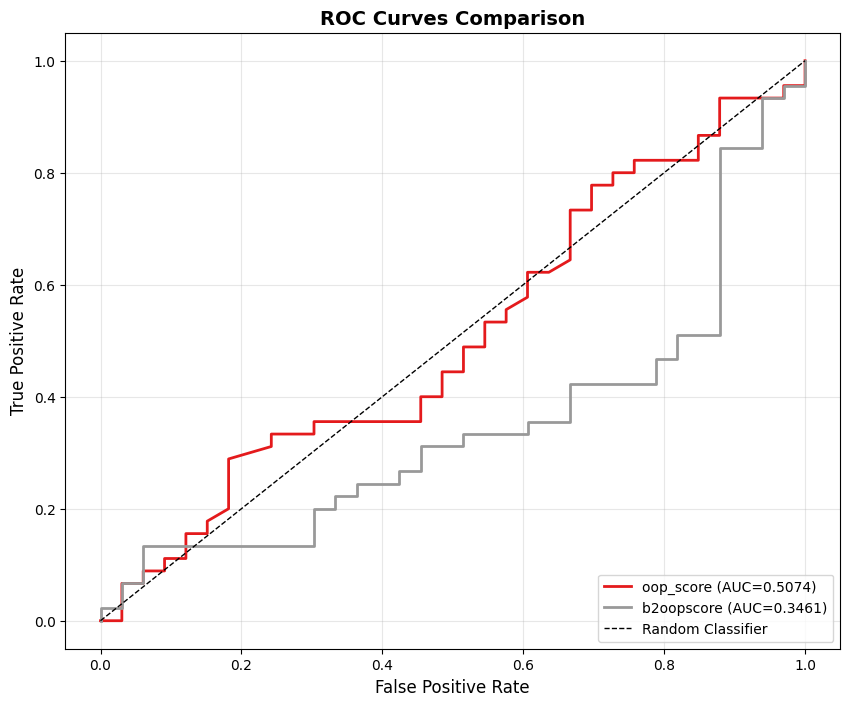

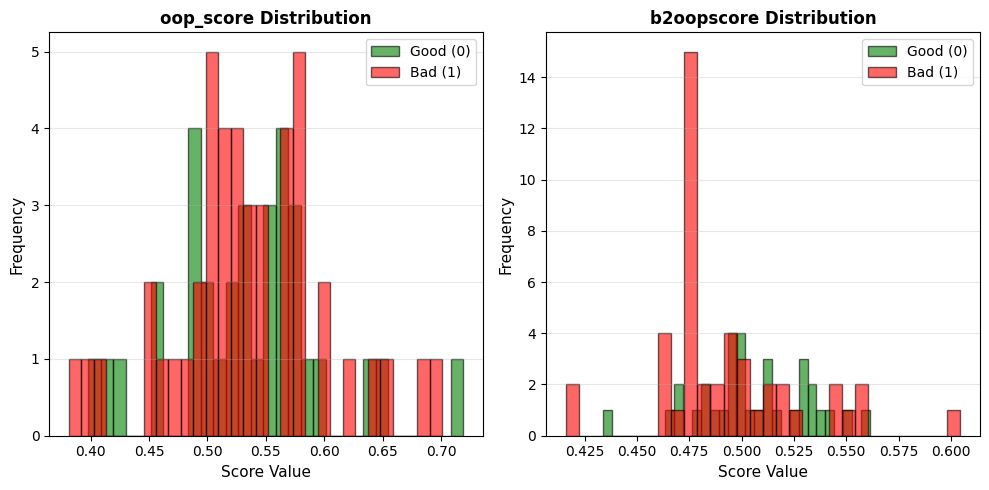

In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

class OverallGiniAnalyzer:
    """
    Overall Gini coefficient analysis without grouping by time periods.
    """
    
    def __init__(self, df, target_col='target', maturity_flag_col='target_maturity_flag'):
        self.df = df.copy()
        self.target_col = target_col
        self.maturity_flag_col = maturity_flag_col
    
    def calculate_gini(self, y_true, y_pred):
        """Gini coefficient: 2*AUC - 1"""
        if y_true.nunique() < 2:
            return np.nan
        auc = roc_auc_score(y_true, y_pred)
        return 2 * auc - 1
    
    def calculate_bad_metrics(self, data=None):
        """Calculate count and percentage of bad"""
        if data is None:
            data = self.df
        count_bad = (data[self.target_col] / data[self.maturity_flag_col]).sum()
        total_count = len(data)
        pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
        return count_bad, pct_bad
    
    def get_score_statistics(self, score_col):
        """Get detailed statistics for a score column"""
        data = self.df[score_col]
        return {
            'Min': data.min(),
            'Max': data.max(),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Q1': data.quantile(0.25),
            'Q3': data.quantile(0.75),
            'Skewness': data.skew(),
            'Kurtosis': data.kurtosis()
        }
    
    def combined_gini(self, score_cols, method='mean'):
        """
        Calculate combined Gini from multiple scores.
        method: 'mean', 'median', 'weighted', 'max', 'min'
        """
        # Normalize scores to [0, 1]
        normalized = pd.DataFrame()
        for col in score_cols:
            min_val = self.df[col].min()
            max_val = self.df[col].max()
            if max_val > min_val:
                normalized[col] = (self.df[col] - min_val) / (max_val - min_val)
            else:
                normalized[col] = 0
        
        # Combine based on method
        if method == 'mean':
            combined_score = normalized.mean(axis=1)
        elif method == 'median':
            combined_score = normalized.median(axis=1)
        elif method == 'max':
            combined_score = normalized.max(axis=1)
        elif method == 'min':
            combined_score = normalized.min(axis=1)
        elif method == 'weighted':
            # Weight by individual Gini scores
            weights = []
            for col in score_cols:
                gini = self.calculate_gini(self.df[self.target_col], self.df[col])
                weights.append(max(gini, 0) + 1)
            weights = np.array(weights) / sum(weights)
            combined_score = (normalized * weights).sum(axis=1)
        
        return self.calculate_gini(self.df[self.target_col], combined_score)
    
    def roc_metrics(self, score_col):
        """Calculate ROC curve metrics"""
        fpr, tpr, thresholds = roc_curve(self.df[self.target_col], self.df[score_col])
        auc = roc_auc_score(self.df[self.target_col], self.df[score_col])
        gini = 2 * auc - 1
        return {'fpr': fpr, 'tpr': tpr, 'auc': auc, 'gini': gini, 'thresholds': thresholds}
    
    def print_summary(self, score_cols):
        """Print comprehensive summary"""
        print("=" * 100)
        print("OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)")
        print("=" * 100)
        
        # Dataset info
        print(f"\nDATASET INFORMATION:")
        print(f"  Total Records: {len(self.df)}")
        print(f"  Target Value Counts:")
        for val, count in self.df[self.target_col].value_counts().items():
            print(f"    {val}: {count}")
        
        # Bad metrics
        count_bad, pct_bad = self.calculate_bad_metrics()
        print(f"\nOVERALL BAD METRICS:")
        print(f"  Count of Bad: {count_bad:.4f}")
        print(f"  Percentage of Bad: {pct_bad:.4f}%")
        
        # Individual scores
        print(f"\nINDIVIDUAL SCORE ANALYSIS:")
        print("-" * 100)
        for score_col in score_cols:
            gini = self.calculate_gini(self.df[self.target_col], self.df[score_col])
            auc = (gini + 1) / 2
            print(f"\n  {score_col}:")
            print(f"    Gini: {gini:.6f}")
            print(f"    AUC:  {auc:.6f}")
            
            # Statistics
            stats = self.get_score_statistics(score_col)
            print(f"    Statistics:")
            print(f"      Min:    {stats['Min']:.6f}")
            print(f"      Max:    {stats['Max']:.6f}")
            print(f"      Mean:   {stats['Mean']:.6f}")
            print(f"      Median: {stats['Median']:.6f}")
            print(f"      Std:    {stats['Std Dev']:.6f}")
        
        # Combined Gini with different methods
        print(f"\nCOMBINED GINI ANALYSIS:")
        print("-" * 100)
        methods = ['mean', 'median', 'max', 'min', 'weighted']
        for method in methods:
            combined = self.combined_gini(score_cols, method=method)
            auc = (combined + 1) / 2
            print(f"  Method '{method}':")
            print(f"    Gini: {combined:.6f}")
            print(f"    AUC:  {auc:.6f}")
    
    def plot_roc_curves(self, score_cols, save_path=None):
        """Plot ROC curves for all scores"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(score_cols)))
        
        for score_col, color in zip(score_cols, colors):
            metrics = self.roc_metrics(score_col)
            ax.plot(metrics['fpr'], metrics['tpr'], label=f"{score_col} (AUC={metrics['auc']:.4f})", 
                   color=color, linewidth=2)
        
        # Diagonal line (random classifier)
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def plot_score_distributions(self, score_cols, save_path=None):
        """Plot distribution of scores by target"""
        fig, axes = plt.subplots(1, len(score_cols), figsize=(5*len(score_cols), 5))
        if len(score_cols) == 1:
            axes = [axes]
        
        for ax, score_col in zip(axes, score_cols):
            bad_scores = self.df[self.df[self.target_col] == 1][score_col]
            good_scores = self.df[self.df[self.target_col] == 0][score_col]
            
            ax.hist(good_scores, bins=30, alpha=0.6, label='Good (0)', color='green', edgecolor='black')
            ax.hist(bad_scores, bins=30, alpha=0.6, label='Bad (1)', color='red', edgecolor='black')
            
            ax.set_xlabel('Score Value', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'{score_col} Distribution', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def export_results(self, score_cols, filename=f'{current_date}_gini_overall_detailed{filname}.xlsx'):
        """Export comprehensive results to Excel"""
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # Summary metrics
            summary_data = []
            for score_col in score_cols:
                gini = self.calculate_gini(self.df[self.target_col], self.df[score_col])
                auc = (gini + 1) / 2
                summary_data.append({
                    'Score Column': score_col,
                    'Gini': gini,
                    'AUC': auc
                })
            
            # Add combined methods
            for method in ['mean', 'median', 'max', 'min', 'weighted']:
                combined = self.combined_gini(score_cols, method=method)
                auc = (combined + 1) / 2
                summary_data.append({
                    'Score Column': f'Combined ({method})',
                    'Gini': combined,
                    'AUC': auc
                })
            
            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='Summary', index=False)
            
            # Score statistics
            stats_data = []
            for score_col in score_cols:
                stats = self.get_score_statistics(score_col)
                stats['Score Column'] = score_col
                stats_data.append(stats)
            
            stats_df = pd.DataFrame(stats_data)
            stats_df.to_excel(writer, sheet_name='Score Statistics', index=False)
            
            # Bad metrics
            count_bad, pct_bad = self.calculate_bad_metrics()
            bad_df = pd.DataFrame({
                'Metric': ['Count of Bad', 'Percentage of Bad (%)', 'Total Records', 
                          'Count Bad (target=1)', 'Count Good (target=0)'],
                'Value': [count_bad, pct_bad, len(self.df), 
                         (self.df[self.target_col] == 1).sum(),
                         (self.df[self.target_col] == 0).sum()]
            })
            bad_df.to_excel(writer, sheet_name='Bad Metrics', index=False)
            
            # Dataset overview
            overview_df = pd.DataFrame({
                'Attribute': ['Total Records', 'Target=0', 'Target=1', 
                            'Maturity Flag=0', 'Maturity Flag=1'],
                'Count': [len(self.df),
                         (self.df[self.target_col] == 0).sum(),
                         (self.df[self.target_col] == 1).sum(),
                         (self.df[self.maturity_flag_col] == 0).sum(),
                         (self.df[self.maturity_flag_col] == 1).sum()]
            })
            overview_df.to_excel(writer, sheet_name='Dataset Overview', index=False)


# Usage Example
if __name__ == "__main__":
    # Load data
    df = filtered_df.copy()
    
    analyzer = OverallGiniAnalyzer(df, target_col='target', maturity_flag_col='target_maturity_flag')
    
    score_cols = ['oop_score', 'b2oopscore']
    
    # Print comprehensive summary
    analyzer.print_summary(score_cols)
    
    # Generate visualizations
    print("\n\nGENERATING VISUALIZATIONS:")
    print("-" * 100)
    analyzer.plot_roc_curves(score_cols, save_path='roc_curves.png')
    print("✓ ROC curves saved to 'roc_curves.png'")
    
    analyzer.plot_score_distributions(score_cols, save_path='score_distributions.png')
    print("✓ Score distributions saved to 'score_distributions.png'")
    
    # Export results
    analyzer.export_results(score_cols, filename='gini_overall_detailed.xlsx')
    print("\n✓ Results exported to 'gini_overall_detailed.xlsx'")

# backscored (OOP v2.0 )	Gini New users 	prod customers


In [65]:
filname = "oopv2_0_bs_PC_gininewuser"

In [ ]:
sq = """
with b1 as (
  select t1.employee_id, t1.ee_appln_submit_dt,
  user_timelines.first_account_activated_at as ee_onboarding_date,
  t1.run_date,
  t1.attrition_model_name,
  t1.ee_attrition_feature,
  t1.ee_attrition_risk_segment,
  t1.ee_attrition_time_to_leave,
  t1.oop_model_name,
  t1.oop_feature,
  t1.oop_score,
  t1.oop_risk_segment,
  t1.subscription_name,
  t1.message_id,
  t1.publish_time,
  t1.attributes
  from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table_api t1
  left join tendopay_raw.user_timelines on cast(user_timelines.user_id as string) = cast(t1.employee_id as string)
  where user_timelines.first_account_activated_at >= '2025-06-01'
    and user_timelines.first_account_activated_at <= '2025-08-31'
  qualify row_number() over(partition by t1.employee_id order by t1.run_date) = 1
),
b2 as (
  select distinct employee_id, run_date, oop_score
  from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table_api
 ),
b3 as (
  select
    b1.employee_id,
    b1.ee_onboarding_date,
    format_date('%Y-%m', date(b1.ee_onboarding_date)) onboarding_month,
    b2.run_date,
    format_date('%Y-%m', date(b2.run_date)) score_month,
    abs(date_diff(date(b2.run_date), date(b1.ee_onboarding_date), day)) as ddiff,
    b1.oop_score,
    b2.oop_score b2oopscore,
    b1.oop_risk_segment
  from b1
  inner join b2 on b2.employee_id = b1.employee_id  -- Use INNER JOIN if you only want matches
)
select b3.*, 
case when b4.target = 0 then 1 
     when b4.target = 1 then 0 
     else 0 end as target, 
b4.target_maturity_flag
from b3
left join prj-prod-dataplatform.tendo_mart.tendo_collection_target_master b4 on b4.user_id = b3.employee_id
where b4.target_maturity_flag = 1
and b3.ddiff < 2 -- Only include records within 2 days of onboarding
qualify row_number() over(partition by b3.employee_id order by b3.ddiff) = 1
order by ee_onboarding_date;
"""

dfd = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The shape of the dataframe is: {dfd.shape}")

dfd.head()

Job ID 48714060-ba7b-4459-a5be-084f353c2f86 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The shape of the dataframe is: (117, 11)


,employee_id,ee_onboarding_date,onboarding_month,run_date,score_month,ddiff,oop_score,b2oopscore,oop_risk_segment,target,target_maturity_flag
0,1462050,2025-06-20 15:25:58+00:00,2025-06,2025-06-20T07:19:49.145921,2025-06,0,0.548142,0.548142,B,1,1
1,1462044,2025-06-21 16:28:01+00:00,2025-06,2025-06-21T08:25:32.194565,2025-06,0,0.559482,0.559482,B,0,1
2,1454272,2025-06-23 13:59:42+00:00,2025-06,2025-06-23T05:55:47.513153,2025-06,0,0.574867,0.574867,A,1,1
3,1470980,2025-07-02 14:32:29+00:00,2025-07,2025-07-02T06:32:10.299994,2025-07,0,0.515797,0.515797,B,0,1
4,1471414,2025-07-03 10:47:02+00:00,2025-07,2025-07-03T02:44:57.825211,2025-07,0,0.571182,0.571182,A,0,1


In [ ]:
dd.query("""select employee_id, count(employee_id) from dfd group by employee_id having count(employee_id) > 1;""")

┌─────────────┬────────────────────┐
│ employee_id │ count(employee_id) │
│   varchar   │       int64        │
├─────────────┴────────────────────┤
│              0 rows              │
└──────────────────────────────────┘

In [ ]:
dfd.groupby('onboarding_month').agg({'employee_id':'nunique'})

,employee_id
onboarding_month,
2025-06,3
2025-07,76
2025-08,38


### Monthly Gini

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_gini(y_true, y_pred):
    """
    Calculate Gini coefficient from actual values and predicted scores.
    Gini = 2 * AUC - 1
    """
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

def gini_by_group(df, score_col, target_col, group_col):
    """
    Calculate Gini coefficient for each group.
    """
    gini_results = {}
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        if len(group_data) > 0 and group_data[target_col].nunique() > 1:
            gini = calculate_gini(group_data[target_col], group_data[score_col])
            gini_results[group] = gini
        else:
            gini_results[group] = np.nan
    return gini_results

def calculate_bad_metrics(df, target_col, maturity_flag_col):
    """
    Calculate count of bad and percentage of bad.
    Bad = target / target_maturity_flag
    """
    count_bad = (df[target_col] / df[maturity_flag_col]).sum()
    total_count = len(df)
    pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
    return count_bad, pct_bad

def bad_metrics_by_group(df, target_col, maturity_flag_col, group_col):
    """
    Calculate bad metrics for each group.
    """
    bad_results = {'count_bad': {}, 'pct_bad': {}}
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        if len(group_data) > 0:
            count_bad, pct_bad = calculate_bad_metrics(group_data, target_col, maturity_flag_col)
            bad_results['count_bad'][group] = count_bad
            bad_results['pct_bad'][group] = pct_bad
    return bad_results

def combined_gini(df, score_cols, target_col):
    """
    Calculate combined Gini for multiple score columns.
    Uses average of normalized scores as combined score.
    """
    # Normalize scores to [0, 1] range
    normalized_scores = pd.DataFrame()
    for col in score_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            normalized_scores[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_scores[col] = 0
    
    # Combined score is average of normalized scores
    combined_score = normalized_scores.mean(axis=1)
    combined_gini_val = calculate_gini(df[target_col], combined_score)
    
    return combined_gini_val

# Load your data
df = dfd.copy()  # Replace with your actual data file

print("=" * 90)
print("GINI COEFFICIENT ANALYSIS WITH BAD METRICS")
print("=" * 90)

# Calculate overall bad metrics
overall_count_bad, overall_pct_bad = calculate_bad_metrics(df, 'target', 'target_maturity_flag')
print(f"\nOVERALL BAD METRICS:")
print(f"  Count of Bad: {overall_count_bad:.2f}")
print(f"  Percentage of Bad: {overall_pct_bad:.2f}%")

# 1. Gini by onboarding_month
print("\n1. GINI BY ONBOARDING_MONTH")
print("-" * 90)
gini_onboarding_oop = gini_by_group(df, 'oop_score', 'target', 'onboarding_month')
gini_onboarding_b2oop = gini_by_group(df, 'b2oopscore', 'target', 'onboarding_month')
bad_onboarding = bad_metrics_by_group(df, 'target', 'target_maturity_flag', 'onboarding_month')

for month in sorted(gini_onboarding_oop.keys()):
    print(f"Month: {month}")
    print(f"  OOP Score Gini:     {gini_onboarding_oop[month]:.6f}")
    print(f"  B2OOP Score Gini:   {gini_onboarding_b2oop[month]:.6f}")
    print(f"  Count of Bad:       {bad_onboarding['count_bad'][month]:.2f}")
    print(f"  Percentage of Bad:  {bad_onboarding['pct_bad'][month]:.2f}%")
    print()

# 2. Gini by score_month
print("\n2. GINI BY SCORE_MONTH")
print("-" * 90)
gini_score_oop = gini_by_group(df, 'oop_score', 'target', 'score_month')
gini_score_b2oop = gini_by_group(df, 'b2oopscore', 'target', 'score_month')
bad_score = bad_metrics_by_group(df, 'target', 'target_maturity_flag', 'score_month')

for month in sorted(gini_score_oop.keys()):
    print(f"Month: {month}")
    print(f"  OOP Score Gini:     {gini_score_oop[month]:.6f}")
    print(f"  B2OOP Score Gini:   {gini_score_b2oop[month]:.6f}")
    print(f"  Count of Bad:       {bad_score['count_bad'][month]:.2f}")
    print(f"  Percentage of Bad:  {bad_score['pct_bad'][month]:.2f}%")
    print()

# 3. Overall Gini (combined for entire dataset)
print("\n3. OVERALL GINI (ENTIRE DATASET)")
print("-" * 90)
overall_gini_oop = calculate_gini(df['target'], df['oop_score'])
overall_gini_b2oop = calculate_gini(df['target'], df['b2oopscore'])
overall_combined_gini = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')

print(f"OOP Score Gini:           {overall_gini_oop:.6f}")
print(f"B2OOP Score Gini:         {overall_gini_b2oop:.6f}")
print(f"Combined Gini:            {overall_combined_gini:.6f}")
print()

# 4. Create summary DataFrame for export
print("\n4. SUMMARY TABLES")
print("-" * 90)

# Summary by onboarding_month
summary_onboarding = pd.DataFrame({
    'onboarding_month': list(gini_onboarding_oop.keys()),
    'oop_score_gini': list(gini_onboarding_oop.values()),
    'b2oopscore_gini': list(gini_onboarding_b2oop.values()),
    'count_bad': list(bad_onboarding['count_bad'].values()),
    'pct_bad': list(bad_onboarding['pct_bad'].values())
})
summary_onboarding['combined_gini'] = summary_onboarding['onboarding_month'].apply(
    lambda m: combined_gini(df[df['onboarding_month'] == m], ['oop_score', 'b2oopscore'], 'target')
    if len(df[df['onboarding_month'] == m]) > 0 and df[df['onboarding_month'] == m]['target'].nunique() > 1
    else np.nan
)
print("\nONBOARDING MONTH SUMMARY:")
print(summary_onboarding.to_string(index=False))

# Summary by score_month
summary_score = pd.DataFrame({
    'score_month': list(gini_score_oop.keys()),
    'oop_score_gini': list(gini_score_oop.values()),
    'b2oopscore_gini': list(gini_score_b2oop.values()),
    'count_bad': list(bad_score['count_bad'].values()),
    'pct_bad': list(bad_score['pct_bad'].values())
})
summary_score['combined_gini'] = summary_score['score_month'].apply(
    lambda m: combined_gini(df[df['score_month'] == m], ['oop_score', 'b2oopscore'], 'target')
    if len(df[df['score_month'] == m]) > 0 and df[df['score_month'] == m]['target'].nunique() > 1
    else np.nan
)
print("\nSCORE MONTH SUMMARY:")
print(summary_score.to_string(index=False))

# Export to Excel
with pd.ExcelWriter(f'{current_date}_gini_analysis_results{filname}.xlsx', engine='openpyxl') as writer:
    summary_onboarding.to_excel(writer, sheet_name='Gini by Onboarding Month', index=False)
    summary_score.to_excel(writer, sheet_name='Gini by Score Month', index=False)
    
    # Overall summary
    overall_summary = pd.DataFrame({
        'Metric': ['OOP Score Gini', 'B2OOP Score Gini', 'Combined Gini', 'Count of Bad', 'Percentage of Bad'],
        'Value': [overall_gini_oop, overall_gini_b2oop, overall_combined_gini, overall_count_bad, overall_pct_bad]
    })
    overall_summary.to_excel(writer, sheet_name='Overall Summary', index=False)

print("\n✓ Results exported to 'gini_analysis_results.xlsx'")

GINI COEFFICIENT ANALYSIS WITH BAD METRICS

OVERALL BAD METRICS:
  Count of Bad: 73.00
  Percentage of Bad: 62.39%

1. GINI BY ONBOARDING_MONTH
------------------------------------------------------------------------------------------
Month: 2025-06
  OOP Score Gini:     0.000000
  B2OOP Score Gini:   0.000000
  Count of Bad:       2.00
  Percentage of Bad:  66.67%

Month: 2025-07
  OOP Score Gini:     0.030990
  B2OOP Score Gini:   0.030990
  Count of Bad:       49.00
  Percentage of Bad:  64.47%

Month: 2025-08
  OOP Score Gini:     0.017045
  B2OOP Score Gini:   -0.005682
  Count of Bad:       22.00
  Percentage of Bad:  57.89%


2. GINI BY SCORE_MONTH
------------------------------------------------------------------------------------------
Month: 2025-06
  OOP Score Gini:     0.000000
  B2OOP Score Gini:   0.000000
  Count of Bad:       2.00
  Percentage of Bad:  66.67%

Month: 2025-07
  OOP Score Gini:     0.030990
  B2OOP Score Gini:   0.030990
  Count of Bad:       49.00
  Perc

In [ ]:
summary_score

,score_month,oop_score_gini,b2oopscore_gini,count_bad,pct_bad,combined_gini
0,2025-06,0.000000,0.000000,2.0,66.666667,0.000000
1,2025-07,0.030990,0.030990,49.0,64.473684,0.030990
2,2025-08,0.017045,-0.005682,22.0,57.894737,0.011364


### Overall Gini Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_gini(y_true, y_pred):
    """
    Calculate Gini coefficient from actual values and predicted scores.
    Gini = 2 * AUC - 1
    """
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

def calculate_bad_metrics(df, target_col, maturity_flag_col):
    """
    Calculate count of bad and percentage of bad.
    Bad = target / target_maturity_flag
    """
    count_bad = (df[target_col] / df[maturity_flag_col]).sum()
    total_count = len(df)
    pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
    return count_bad, pct_bad

def combined_gini(df, score_cols, target_col):
    """
    Calculate combined Gini for multiple score columns.
    Uses average of normalized scores as combined score.
    """
    # Normalize scores to [0, 1] range
    normalized_scores = pd.DataFrame()
    for col in score_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            normalized_scores[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_scores[col] = 0
    
    # Combined score is average of normalized scores
    combined_score = normalized_scores.mean(axis=1)
    combined_gini_val = calculate_gini(df[target_col], combined_score)
    
    return combined_gini_val

# Load your data
df = dfd.copy()  # Replace with your actual data file

print("=" * 90)
print("OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)")
print("=" * 90)

# Dataset Information
print(f"\nDATASET INFORMATION:")
print(f"  Total Records: {len(df)}")
print(f"  Target Value Counts:\n{df['target'].value_counts()}")

# Overall Bad Metrics
overall_count_bad, overall_pct_bad = calculate_bad_metrics(df, 'target', 'target_maturity_flag')
print(f"\nOVERALL BAD METRICS:")
print(f"  Count of Bad: {overall_count_bad:.4f}")
print(f"  Percentage of Bad: {overall_pct_bad:.4f}%")

# Individual Score Gini
print(f"\nINDIVIDUAL SCORE GINI:")
print("-" * 90)
overall_gini_oop = calculate_gini(df['target'], df['oop_score'])
overall_gini_b2oop = calculate_gini(df['target'], df['b2oopscore'])

print(f"  OOP Score:")
print(f"    Gini: {overall_gini_oop:.6f}")
print(f"    AUC:  {(overall_gini_oop + 1) / 2:.6f}")

print(f"\n  B2OOP Score:")
print(f"    Gini: {overall_gini_b2oop:.6f}")
print(f"    AUC:  {(overall_gini_b2oop + 1) / 2:.6f}")

# Combined Gini
print(f"\nCOMBINED GINI:")
print("-" * 90)
overall_combined_gini = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')

print(f"  Combined Score (Mean Normalized):")
print(f"    Gini: {overall_combined_gini:.6f}")
print(f"    AUC:  {(overall_combined_gini + 1) / 2:.6f}")

# Score Statistics
print(f"\nSCORE STATISTICS:")
print("-" * 90)
print(f"\n  OOP Score:")
print(f"    Min:  {df['oop_score'].min():.6f}")
print(f"    Max:  {df['oop_score'].max():.6f}")
print(f"    Mean: {df['oop_score'].mean():.6f}")
print(f"    Std:  {df['oop_score'].std():.6f}")

print(f"\n  B2OOP Score:")
print(f"    Min:  {df['b2oopscore'].min():.6f}")
print(f"    Max:  {df['b2oopscore'].max():.6f}")
print(f"    Mean: {df['b2oopscore'].mean():.6f}")
print(f"    Std:  {df['b2oopscore'].std():.6f}")

# Create Summary DataFrame
summary_overall = pd.DataFrame({
    'Metric': [
        'OOP Score Gini',
        'OOP Score AUC',
        'B2OOP Score Gini',
        'B2OOP Score AUC',
        'Combined Gini',
        'Combined AUC',
        'Count of Bad',
        'Percentage of Bad',
        'Total Records',
        'Bad Count (target=1)',
        'Good Count (target=0)'
    ],
    'Value': [
        overall_gini_oop,
        (overall_gini_oop + 1) / 2,
        overall_gini_b2oop,
        (overall_gini_b2oop + 1) / 2,
        overall_combined_gini,
        (overall_combined_gini + 1) / 2,
        overall_count_bad,
        overall_pct_bad,
        len(df),
        (df['target'] == 1).sum(),
        (df['target'] == 0).sum()
    ]
})

print(f"\nSUMMARY TABLE:")
print("-" * 90)
print(summary_overall.to_string(index=False))

# Export to Excel
with pd.ExcelWriter(f'{current_date}_gini_overall_analysis_{filname}.xlsx', engine='openpyxl') as writer:
    summary_overall.to_excel(writer, sheet_name='Overall Summary', index=False)
    
    # Detailed score statistics
    score_stats = pd.DataFrame({
        'Score Column': ['OOP Score', 'B2OOP Score'],
        'Min': [df['oop_score'].min(), df['b2oopscore'].min()],
        'Max': [df['oop_score'].max(), df['b2oopscore'].max()],
        'Mean': [df['oop_score'].mean(), df['b2oopscore'].mean()],
        'Median': [df['oop_score'].median(), df['b2oopscore'].median()],
        'Std Dev': [df['oop_score'].std(), df['b2oopscore'].std()],
        'Gini': [overall_gini_oop, overall_gini_b2oop],
        'AUC': [(overall_gini_oop + 1) / 2, (overall_gini_b2oop + 1) / 2]
    })
    score_stats.to_excel(writer, sheet_name='Score Statistics', index=False)

print(f"\n✓ Results exported to '{current_date}_gini_overall_analysis.xlsx'")

OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)

DATASET INFORMATION:
  Total Records: 117
  Target Value Counts:
target
1    73
0    44
Name: count, dtype: Int64

OVERALL BAD METRICS:
  Count of Bad: 73.0000
  Percentage of Bad: 62.3932%

INDIVIDUAL SCORE GINI:
------------------------------------------------------------------------------------------
  OOP Score:
    Gini: 0.019925
    AUC:  0.509963

  B2OOP Score:
    Gini: 0.011208
    AUC:  0.505604

COMBINED GINI:
------------------------------------------------------------------------------------------
  Combined Score (Mean Normalized):
    Gini: 0.015567
    AUC:  0.507783

SCORE STATISTICS:
------------------------------------------------------------------------------------------

  OOP Score:
    Min:  0.381393
    Max:  0.718999
    Mean: 0.535495
    Std:  0.066635

  B2OOP Score:
    Min:  0.381393
    Max:  0.718999
    Mean: 0.534892
    Std:  0.067187

SUMMARY TABLE:
----------------------------------------------------

In [ ]:
score_stats

,Score Column,Min,Max,Mean,Median,Std Dev,Gini,AUC
0,OOP Score,0.381393,0.718999,0.535495,0.528347,0.066635,0.019925,0.509963
1,B2OOP Score,0.381393,0.718999,0.534892,0.528347,0.067187,0.011208,0.505604


In [ ]:
summary_overall_transposed = summary_overall.set_index('Metric').T
summary_overall_transposed

Metric,OOP Score Gini,OOP Score AUC,B2OOP Score Gini,B2OOP Score AUC,Combined Gini,Combined AUC,Count of Bad,Percentage of Bad,Total Records,Bad Count (target=1),Good Count (target=0)
Value,0.019925,0.509963,0.011208,0.505604,0.015567,0.507783,73.0,62.393162,117.0,73.0,44.0


### Overall gini_analysis_advanced

OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)

DATASET INFORMATION:
  Total Records: 117
  Target Value Counts:
    1: 73
    0: 44

OVERALL BAD METRICS:
  Count of Bad: 73.0000
  Percentage of Bad: 62.3932%

INDIVIDUAL SCORE ANALYSIS:
----------------------------------------------------------------------------------------------------

  oop_score:
    Gini: 0.019925
    AUC:  0.509963
    Statistics:
      Min:    0.381393
      Max:    0.718999
      Mean:   0.535495
      Median: 0.528347
      Std:    0.066635

  b2oopscore:
    Gini: 0.011208
    AUC:  0.505604
    Statistics:
      Min:    0.381393
      Max:    0.718999
      Mean:   0.534892
      Median: 0.528347
      Std:    0.067187

COMBINED GINI ANALYSIS:
----------------------------------------------------------------------------------------------------
  Method 'mean':
    Gini: 0.015567
    AUC:  0.507783
  Method 'median':
    Gini: 0.015567
    AUC:  0.507783
  Method 'max':
    Gini: 0.018680
    AUC:  0.509340
  

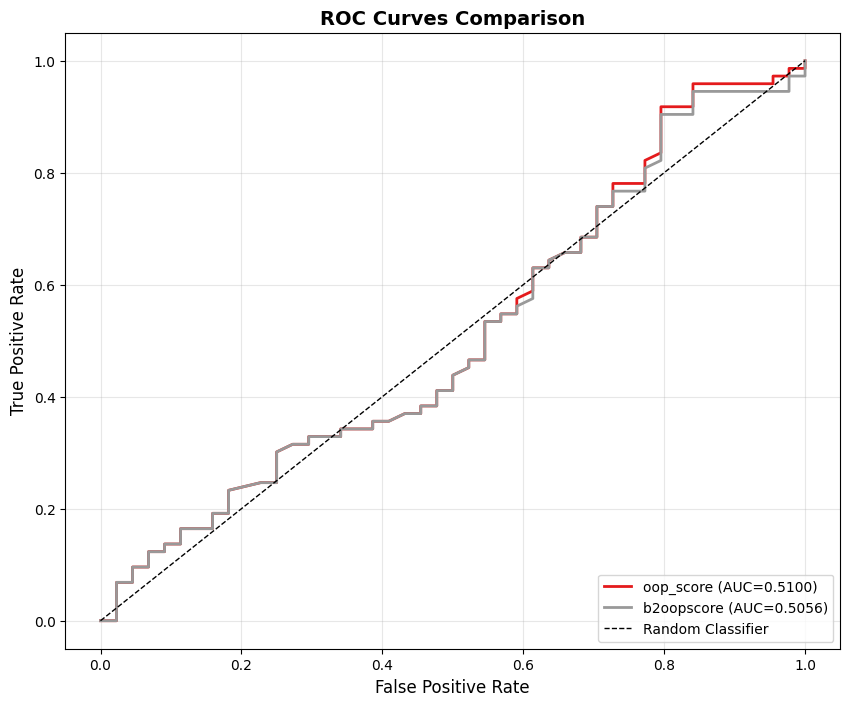

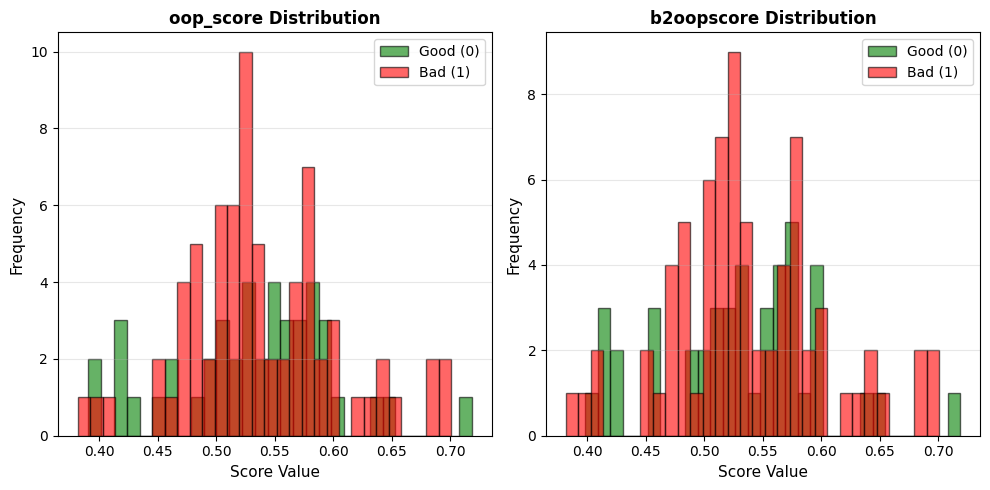

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

class OverallGiniAnalyzer:
    """
    Overall Gini coefficient analysis without grouping by time periods.
    """
    
    def __init__(self, df, target_col='target', maturity_flag_col='target_maturity_flag'):
        self.df = df.copy()
        self.target_col = target_col
        self.maturity_flag_col = maturity_flag_col
    
    def calculate_gini(self, y_true, y_pred):
        """Gini coefficient: 2*AUC - 1"""
        if y_true.nunique() < 2:
            return np.nan
        auc = roc_auc_score(y_true, y_pred)
        return 2 * auc - 1
    
    def calculate_bad_metrics(self, data=None):
        """Calculate count and percentage of bad"""
        if data is None:
            data = self.df
        count_bad = (data[self.target_col] / data[self.maturity_flag_col]).sum()
        total_count = len(data)
        pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
        return count_bad, pct_bad
    
    def get_score_statistics(self, score_col):
        """Get detailed statistics for a score column"""
        data = self.df[score_col]
        return {
            'Min': data.min(),
            'Max': data.max(),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Q1': data.quantile(0.25),
            'Q3': data.quantile(0.75),
            'Skewness': data.skew(),
            'Kurtosis': data.kurtosis()
        }
    
    def combined_gini(self, score_cols, method='mean'):
        """
        Calculate combined Gini from multiple scores.
        method: 'mean', 'median', 'weighted', 'max', 'min'
        """
        # Normalize scores to [0, 1]
        normalized = pd.DataFrame()
        for col in score_cols:
            min_val = self.df[col].min()
            max_val = self.df[col].max()
            if max_val > min_val:
                normalized[col] = (self.df[col] - min_val) / (max_val - min_val)
            else:
                normalized[col] = 0
        
        # Combine based on method
        if method == 'mean':
            combined_score = normalized.mean(axis=1)
        elif method == 'median':
            combined_score = normalized.median(axis=1)
        elif method == 'max':
            combined_score = normalized.max(axis=1)
        elif method == 'min':
            combined_score = normalized.min(axis=1)
        elif method == 'weighted':
            # Weight by individual Gini scores
            weights = []
            for col in score_cols:
                gini = self.calculate_gini(self.df[self.target_col], self.df[col])
                weights.append(max(gini, 0) + 1)
            weights = np.array(weights) / sum(weights)
            combined_score = (normalized * weights).sum(axis=1)
        
        return self.calculate_gini(self.df[self.target_col], combined_score)
    
    def roc_metrics(self, score_col):
        """Calculate ROC curve metrics"""
        fpr, tpr, thresholds = roc_curve(self.df[self.target_col], self.df[score_col])
        auc = roc_auc_score(self.df[self.target_col], self.df[score_col])
        gini = 2 * auc - 1
        return {'fpr': fpr, 'tpr': tpr, 'auc': auc, 'gini': gini, 'thresholds': thresholds}
    
    def print_summary(self, score_cols):
        """Print comprehensive summary"""
        print("=" * 100)
        print("OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)")
        print("=" * 100)
        
        # Dataset info
        print(f"\nDATASET INFORMATION:")
        print(f"  Total Records: {len(self.df)}")
        print(f"  Target Value Counts:")
        for val, count in self.df[self.target_col].value_counts().items():
            print(f"    {val}: {count}")
        
        # Bad metrics
        count_bad, pct_bad = self.calculate_bad_metrics()
        print(f"\nOVERALL BAD METRICS:")
        print(f"  Count of Bad: {count_bad:.4f}")
        print(f"  Percentage of Bad: {pct_bad:.4f}%")
        
        # Individual scores
        print(f"\nINDIVIDUAL SCORE ANALYSIS:")
        print("-" * 100)
        for score_col in score_cols:
            gini = self.calculate_gini(self.df[self.target_col], self.df[score_col])
            auc = (gini + 1) / 2
            print(f"\n  {score_col}:")
            print(f"    Gini: {gini:.6f}")
            print(f"    AUC:  {auc:.6f}")
            
            # Statistics
            stats = self.get_score_statistics(score_col)
            print(f"    Statistics:")
            print(f"      Min:    {stats['Min']:.6f}")
            print(f"      Max:    {stats['Max']:.6f}")
            print(f"      Mean:   {stats['Mean']:.6f}")
            print(f"      Median: {stats['Median']:.6f}")
            print(f"      Std:    {stats['Std Dev']:.6f}")
        
        # Combined Gini with different methods
        print(f"\nCOMBINED GINI ANALYSIS:")
        print("-" * 100)
        methods = ['mean', 'median', 'max', 'min', 'weighted']
        for method in methods:
            combined = self.combined_gini(score_cols, method=method)
            auc = (combined + 1) / 2
            print(f"  Method '{method}':")
            print(f"    Gini: {combined:.6f}")
            print(f"    AUC:  {auc:.6f}")
    
    def plot_roc_curves(self, score_cols, save_path=None):
        """Plot ROC curves for all scores"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(score_cols)))
        
        for score_col, color in zip(score_cols, colors):
            metrics = self.roc_metrics(score_col)
            ax.plot(metrics['fpr'], metrics['tpr'], label=f"{score_col} (AUC={metrics['auc']:.4f})", 
                   color=color, linewidth=2)
        
        # Diagonal line (random classifier)
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def plot_score_distributions(self, score_cols, save_path=None):
        """Plot distribution of scores by target"""
        fig, axes = plt.subplots(1, len(score_cols), figsize=(5*len(score_cols), 5))
        if len(score_cols) == 1:
            axes = [axes]
        
        for ax, score_col in zip(axes, score_cols):
            bad_scores = self.df[self.df[self.target_col] == 1][score_col]
            good_scores = self.df[self.df[self.target_col] == 0][score_col]
            
            ax.hist(good_scores, bins=30, alpha=0.6, label='Good (0)', color='green', edgecolor='black')
            ax.hist(bad_scores, bins=30, alpha=0.6, label='Bad (1)', color='red', edgecolor='black')
            
            ax.set_xlabel('Score Value', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'{score_col} Distribution', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def export_results(self, score_cols, filename=f'{current_date}_gini_overall_detailed{filname}.xlsx'):
        """Export comprehensive results to Excel"""
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # Summary metrics
            summary_data = []
            for score_col in score_cols:
                gini = self.calculate_gini(self.df[self.target_col], self.df[score_col])
                auc = (gini + 1) / 2
                summary_data.append({
                    'Score Column': score_col,
                    'Gini': gini,
                    'AUC': auc
                })
            
            # Add combined methods
            for method in ['mean', 'median', 'max', 'min', 'weighted']:
                combined = self.combined_gini(score_cols, method=method)
                auc = (combined + 1) / 2
                summary_data.append({
                    'Score Column': f'Combined ({method})',
                    'Gini': combined,
                    'AUC': auc
                })
            
            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='Summary', index=False)
            
            # Score statistics
            stats_data = []
            for score_col in score_cols:
                stats = self.get_score_statistics(score_col)
                stats['Score Column'] = score_col
                stats_data.append(stats)
            
            stats_df = pd.DataFrame(stats_data)
            stats_df.to_excel(writer, sheet_name='Score Statistics', index=False)
            
            # Bad metrics
            count_bad, pct_bad = self.calculate_bad_metrics()
            bad_df = pd.DataFrame({
                'Metric': ['Count of Bad', 'Percentage of Bad (%)', 'Total Records', 
                          'Count Bad (target=1)', 'Count Good (target=0)'],
                'Value': [count_bad, pct_bad, len(self.df), 
                         (self.df[self.target_col] == 1).sum(),
                         (self.df[self.target_col] == 0).sum()]
            })
            bad_df.to_excel(writer, sheet_name='Bad Metrics', index=False)
            
            # Dataset overview
            overview_df = pd.DataFrame({
                'Attribute': ['Total Records', 'Target=0', 'Target=1', 
                            'Maturity Flag=0', 'Maturity Flag=1'],
                'Count': [len(self.df),
                         (self.df[self.target_col] == 0).sum(),
                         (self.df[self.target_col] == 1).sum(),
                         (self.df[self.maturity_flag_col] == 0).sum(),
                         (self.df[self.maturity_flag_col] == 1).sum()]
            })
            overview_df.to_excel(writer, sheet_name='Dataset Overview', index=False)


# Usage Example
if __name__ == "__main__":
    # Load data
    df = dfd.copy()
    
    analyzer = OverallGiniAnalyzer(df, target_col='target', maturity_flag_col='target_maturity_flag')
    
    score_cols = ['oop_score', 'b2oopscore']
    
    # Print comprehensive summary
    analyzer.print_summary(score_cols)
    
    # Generate visualizations
    print("\n\nGENERATING VISUALIZATIONS:")
    print("-" * 100)
    analyzer.plot_roc_curves(score_cols, save_path='roc_curves.png')
    print("✓ ROC curves saved to 'roc_curves.png'")
    
    analyzer.plot_score_distributions(score_cols, save_path='score_distributions.png')
    print("✓ Score distributions saved to 'score_distributions.png'")
    
    # Export results
    analyzer.export_results(score_cols, filename='gini_overall_detailed.xlsx')
    print("\n✓ Results exported to 'gini_overall_detailed.xlsx'")

# End